In [10]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
warnings.filterwarnings('ignore')
from matplotlib import colors as mcolors
from matplotlib import cm
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from scipy.stats import zscore
from scipy.stats import ttest_ind
from sklearn.cross_decomposition import CCA
from trimesh import load_mesh
from joblib import Parallel, delayed
from utils.plot_utils import shiftedColorMap, template_reorder, plot_raster_bar,merge_pdfs, combine_pdf_big
%matplotlib inline

In [2]:
criteria_name = 'beh_all'

In [3]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/scratch/combined/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

In [4]:
for col, cfg in constraints.items():
    if col not in combined_tagged_units.columns:
        continue

    # Numeric range?
    if "bounds" in cfg:
        print(f'Applying bounds for {col}: {cfg["bounds"]}')
        lb, ub = np.array(cfg["bounds"], dtype=float)  # np.nan for null
        if not np.isnan(lb):
            mask &= combined_tagged_units[col] >= lb
        if not np.isnan(ub):
            mask &= combined_tagged_units[col] <= ub

    # Categorical list?
    elif "items" in cfg:
        print(f'Applying items for {col}: {cfg["items"]}')
        allowed = cfg["items"]
        mask &= combined_tagged_units[col].isin(allowed)

# apply and get filtered DataFrame
combined_tagged_units_filtered = combined_tagged_units[mask].reset_index(drop=True)
combined_tagged_units['selected'] = mask
print(f'Number of units after filtering: {len(combined_tagged_units_filtered)}')
# Save the filtered units
with open(os.path.join(beh_folder, f'filtered_units_{criteria_name}.pkl'), 'wb') as f:
    pickle.dump(combined_tagged_units_filtered, f)
session_list = combined_tagged_units_filtered['session'].unique().tolist()

Applying bounds for isi_violations: [0.0, 0.1]
Applying bounds for p_max: [0.5, 1.0]
Applying bounds for lat_max_p: [0.005, 0.02]
Applying bounds for eu: [0.0, 0.25]
Applying bounds for corr: [0.95, 1.0]
Applying items for qc_pass: [True]
Applying bounds for peak: [-1000, 0]
Applying bounds for trial_count: [100, 2000]
Applying items for in_df: [True]
Number of units after filtering: 97


In [34]:
# load behavior data
def burst_analysis(session, data_type, units = None):
    print(f'Processing session {session} for data type {data_type}')
    unit_tbl = get_unit_tbl(session, data_type)
    session_df = get_session_tbl(session)
    session_dir = session_dirs(session, data_type)
    save_path = os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], 'burst')
    if os.path.exists(save_path) is False:
        os.makedirs(save_path)
    if units is None:
        units = unit_tbl['unit_id'].tolist()
    for unit_id in units:
        if not unit_tbl[unit_tbl['unit_id']==unit_id]['tagged_loc'].values[0]:
            continue
        spike_times = unit_tbl[unit_tbl['unit_id']==unit_id]['spike_times'].values[0]
        pre_event = -0.1
        post_event= 0.1
        session_df_curr = session_df.copy()
        spike_times_curr = spike_times.copy()
        unit_drift = load_drift(session, unit_id, data_type=data_type)

        if unit_drift is not None:
            if unit_drift['ephys_cut'][0] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
                session_df_curr = session_df_curr[session_df_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
            if unit_drift['ephys_cut'][1] is not None:
                spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
                session_df_curr = session_df_curr[session_df_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
        if len(session_df_curr) <=20:
            print(f'Skipping {unit_id} due to insufficient trials after drift cut.')
            continue
        # align to go cue sorted by choice time, separate by choice or not
        # from start to end
        fig = plt.figure(figsize=(14,10))
        gs = gridspec.GridSpec(2,6)
        lick_lat = session_df_curr['reward_outcome_time'].values - session_df_curr['goCue_start_time'].values
        lick_lat[session_df_curr['animal_response'].values==2] = np.nan
        pre_event = -0.1
        post_event= 0.1
        align_time = session_df_curr['goCue_start_time'].values
        align_time_licklat_sort = align_time[np.argsort(lick_lat)]
        ax = fig.add_subplot(gs[0, 0])  
        df = align.to_events(spike_times_curr, align_time_licklat_sort, (pre_event, post_event), return_df=True)
        plt.plot([0,0],[0,df.event_index.max()],'r', zorder = 1)
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1, zorder = 2)
        ax.set_xlim(pre_event, post_event)
        ax.set_ylabel('Lick latency sorted trials')
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(0, len(session_df_curr))
        ax.axhline(len(align_time_licklat_sort)-np.sum(session_df_curr['animal_response'].values==2), color='blue', linestyle='--')
        ax.set_title('Aligned to Go Cue')

        align_time = session_df_curr['reward_outcome_time'].values
        lick_lat[session_df_curr['animal_response'].values==2] = np.nan
        align_time_licklat_sort = align_time[np.argsort(lick_lat)]
        ax = fig.add_subplot(gs[0, 1])  
        df = align.to_events(spike_times_curr, align_time_licklat_sort, (pre_event, post_event), return_df=True)
        plt.plot([0,0],[0,df.event_index.max()],'r', zorder = 1)
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1, zorder = 2)
        ax.set_xlim(pre_event, post_event)
        ax.set_ylabel('Lick latency sorted trials')
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(0, len(session_df_curr))
        ax.axhline(len(align_time_licklat_sort)-np.sum(session_df_curr['animal_response'].values==2), color='blue', linestyle='--')
        ax.set_title('Aligned to Choice')


        # align to go cue and sort by frist spike time
        align_time = session_df_curr['goCue_start_time'].values
        spike_df = align.to_events(spike_times_curr, align_time, (0, 10), return_df=True)
        # for each value in event_index, get the first spike time
        first_spike_times = np.full(len(session_df_curr), np.nan)
        for i in range(len(session_df_curr)):
            spikes_in_trial = spike_df[spike_df['event_index']==i]['time']
            if len(spikes_in_trial) > 0:
                first_spike_times[i] = spikes_in_trial.min()
        # first_spike_times = np.full(len(session_df_curr), np.nan)
        align_time_firstspike_sort = align_time[np.argsort(first_spike_times)]
        ax = fig.add_subplot(gs[0, 2])
        df = align.to_events(spike_times_curr, align_time_firstspike_sort, (pre_event, post_event), return_df=True)
        plt.plot([0,0],[0,df.event_index.max()],'r', zorder = 1)
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1, zorder = 2)
        ax.set_xlim(pre_event, post_event)
        ax.set_ylabel('First spike time sorted trials')
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(0, len(session_df_curr))
        ax.set_title('Aligned to Go Cue')

        # align to first spike time
        first_spike_times_abs = first_spike_times + session_df_curr['goCue_start_time'].values
        first_spike_times_abs_sorted = first_spike_times_abs[np.argsort(first_spike_times)]
        df = align.to_events(spike_times_curr, first_spike_times_abs_sorted, (-0.05, 0.03), return_df=True)
        plt.plot([0,0],[0,df.event_index.max()],'r', zorder = 1)
        ax = fig.add_subplot(gs[0, 3])
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=1, zorder = 2)
        ax.set_xlim(-0.05, 0.03)
        ax.set_ylabel('Sorted by First Spike Time to go cue')
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(0, len(session_df_curr))
        ax.set_title('Aligned to First Spike Time')

        # isi distribution
        ax = fig.add_subplot(gs[1, 3:5])
        isi_spikes = np.log(np.diff(spike_times_curr))
        edges = np.linspace(np.nanmin(isi_spikes), np.nanmax(isi_spikes), 50)
        ax.hist(isi_spikes, bins=edges, color='k', alpha = 0.5, density=True)
        # set xlabel to log
        ax.axvline(np.log(0.002), color='k', linestyle='--')
        ax.set_xlabel('log(Inter-spike interval (s))')
        ax.set_ylabel('Density')
        ax.set_title('log(ISI) Distribution')

        # color by isi
        first_spike_times_abs = first_spike_times + session_df_curr['goCue_start_time'].values
        first_spike_times_abs_sorted = first_spike_times_abs[np.argsort(first_spike_times)]
        df = align.to_events(spike_times_curr, first_spike_times_abs_sorted, (-0.05, 0.03), return_df=True)

        isi_list = df.copy()
        isi_list['isi'] = np.nan
        # infer time interval of previous spike for each spike
        for ind, row in isi_list.iterrows():
            event_index = row['event_index']
            time = row['time']
            prev_spikes = spike_times_curr[spike_times_curr < (time + first_spike_times_abs_sorted[int(event_index)])]
            if len(prev_spikes) == 0:
                isi_list.at[ind, 'isi'] = np.nan
            else:
                isi_list.at[ind, 'isi'] = time + first_spike_times_abs_sorted[[int(event_index)]] - prev_spikes[-1]

        isi_color_code = np.log(isi_list['isi'].values)
        up_bound = np.percentile(isi_color_code[~np.isnan(isi_color_code)], 95)
        low_bound = np.percentile(isi_color_code[~np.isnan(isi_color_code)], 5)
        isi_color_code = (isi_color_code - low_bound) / (up_bound - low_bound)
        isi_color_code[isi_color_code>1] = 1
        isi_color_code[isi_color_code<0] = 0

        ax.hist(np.log(isi_list['isi'].values), bins=50, color='r', alpha=0.5, density=True)
        ax.axvline(low_bound, color='b', linestyle='--')
        ax.axvline(up_bound, color='r', linestyle='--')

        ax= fig.add_subplot(gs[0,4])
        sc = ax.scatter(df.time, df.event_index, c=isi_color_code, marker= '|', s=4, zorder = 2, cmap='Reds_r')
        ax.set_xlim(-0.02, 0.03)
        ax.set_ylabel('Sorted by First Spike Time to go cue')
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(0, len(session_df_curr))
        ax.set_title('Aligned to First Spike Time')

        # add colorbar
        ax = fig.add_subplot(gs[1,5])
        cbar = plt.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)

        # align to go cue and sort by frist spike time
        align_time = session_df_curr['goCue_start_time'].values
        spike_df = align.to_events(spike_times_curr, align_time, (0, 100), return_df=True)
        # for each value in event_index, get the first spike time
        first_spike_times = spike_df.groupby('event_index')['time'].min().values
        align_time_firstspike_sort = align_time[np.argsort(first_spike_times)]
        df = align.to_events(spike_times_curr, align_time_firstspike_sort, (pre_event, post_event), return_df=True)
        isi_list = df.copy()
        isi_list['isi'] = np.nan
        # infer time interval of previous spike for each spike
        for ind, row in isi_list.iterrows():
            event_index = row['event_index']
            time = row['time']
            prev_spikes = spike_times_curr[spike_times_curr < (time + align_time_firstspike_sort[int(event_index)])]
            if len(prev_spikes) == 0:
                isi_list.at[ind, 'isi'] = np.nan
            else:
                isi_list.at[ind, 'isi'] = time + align_time_firstspike_sort[[int(event_index)]] - prev_spikes[-1]

        isi_color_code = np.log(isi_list['isi'].values)
        isi_color_code = (isi_color_code - low_bound) / (up_bound - low_bound)
        isi_color_code[isi_color_code>1] = 1
        isi_color_code[isi_color_code<0] = 0

        # plt.plot([0,0],[0,df.event_index.max()],'r', zorder = 1)
        ax = fig.add_subplot(gs[0, 5])
        ax.scatter(df.time, df.event_index, c=isi_color_code, marker= '|', s=3, zorder = 2, cmap = 'Reds_r')
        ax.set_xlim(pre_event, post_event)
        ax.set_ylabel('First spike time sorted trials')
        ax.tick_params(axis='both', which='major')
        ax.set_xlim(-0.02, 0.03)
        ax.set_title('Aligned to Go Cue')


        pre_event = -1.7
        post_event = 0.1
        align_time = session_df_curr['goCue_start_time'].values
        align_time_licklat_sort = align_time[np.argsort(lick_lat)]
        ax = fig.add_subplot(gs[1, 0])  
        df = align.to_events(spike_times_curr, align_time_licklat_sort, (pre_event, post_event), return_df=True)
        plt.plot([0,0],[0,df.event_index.max()],'r', zorder = 1)
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=3, zorder = 2)
        ax.set_xlim(pre_event, post_event)
        ax.set_ylabel('Lick latency sorted trials')
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(0, len(session_df_curr))
        ax.axhline(len(align_time_licklat_sort)-np.sum(session_df_curr['animal_response'].values==2), color='blue', linestyle='--')
        ax.set_title('Aligned to Go Cue')


        align_time = session_df_curr['reward_outcome_time'].values
        lick_lat[session_df_curr['animal_response'].values==2] = np.nan
        align_time_licklat_sort = align_time[np.argsort(lick_lat)]
        ax = fig.add_subplot(gs[1, 1])  
        df = align.to_events(spike_times_curr, align_time_licklat_sort, (pre_event, post_event), return_df=True)
        plt.plot([0,0],[0,df.event_index.max()],'r', zorder = 1)
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=3, zorder = 2)
        ax.set_xlim(pre_event, post_event)
        ax.set_ylabel('Lick latency sorted trials')
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(0, len(session_df_curr))
        ax.axhline(len(align_time_licklat_sort)-np.sum(session_df_curr['animal_response'].values==2), color='blue', linestyle='--')
        ax.set_title('Aligned to Choice')


        # align to go cue and sort by frist spike time
        post_event = 1
        pre_event = -0.5
        align_time = session_df_curr['goCue_start_time'].values
        spike_df = align.to_events(spike_times_curr, align_time, (0, 100), return_df=True)
        # for each value in event_index, get the first spike time
        first_spike_times = spike_df.groupby('event_index')['time'].min().values
        align_time_firstspike_sort = align_time[np.argsort(first_spike_times)]
        ax = fig.add_subplot(gs[1, 2])
        df = align.to_events(spike_times_curr, align_time_firstspike_sort, (pre_event, post_event), return_df=True)
        plt.plot([0,0],[0,df.event_index.max()],'r', zorder = 1)
        ax.scatter(df.time, df.event_index, c='k', marker= '|', s=4, zorder = 2)
        trial_ind = np.argsort(first_spike_times)
        lick_time = session_df_curr['reward_outcome_time'].values[trial_ind] - session_df_curr['goCue_start_time'].values[trial_ind]
        ax.scatter(lick_time, np.arange(len(session_df_curr)), c='b', label='Lick Time', marker= '|', s=4)
        ax.set_xlim(pre_event, post_event)
        ax.set_ylabel('First spike time sorted trials')
        ax.tick_params(axis='both', which='major')
        ax.set_ylim(0, len(session_df_curr))
        ax.axhline(len(align_time_firstspike_sort)-np.sum(session_df_curr['animal_response'].values==2), color='blue', linestyle='--')
        ax.set_title('Aligned to Go Cue') 

        plt.suptitle(f'Session {session}, Unit {unit_id}')
        plt.tight_layout()
        fig.savefig(os.path.join(save_path, f'opto_{session}{unit_id}_burst_selected.pdf'), dpi=300)
        plt.close(fig)

    print(f'{session} Combining PDFs...')
    combine_pdf_big(save_path, os.path.join(session_dir[f'ephys_fig_dir_{data_type}'], f'{session}_bursting.pdf'))
    print(f'{session} Done!')


10
11
17
20
21
26
27
28
30
31
35
39
40
41
43
45
46
47
48
49
52
53
54
56
57
58
59
61
62
64
67
69
241
242
281
283


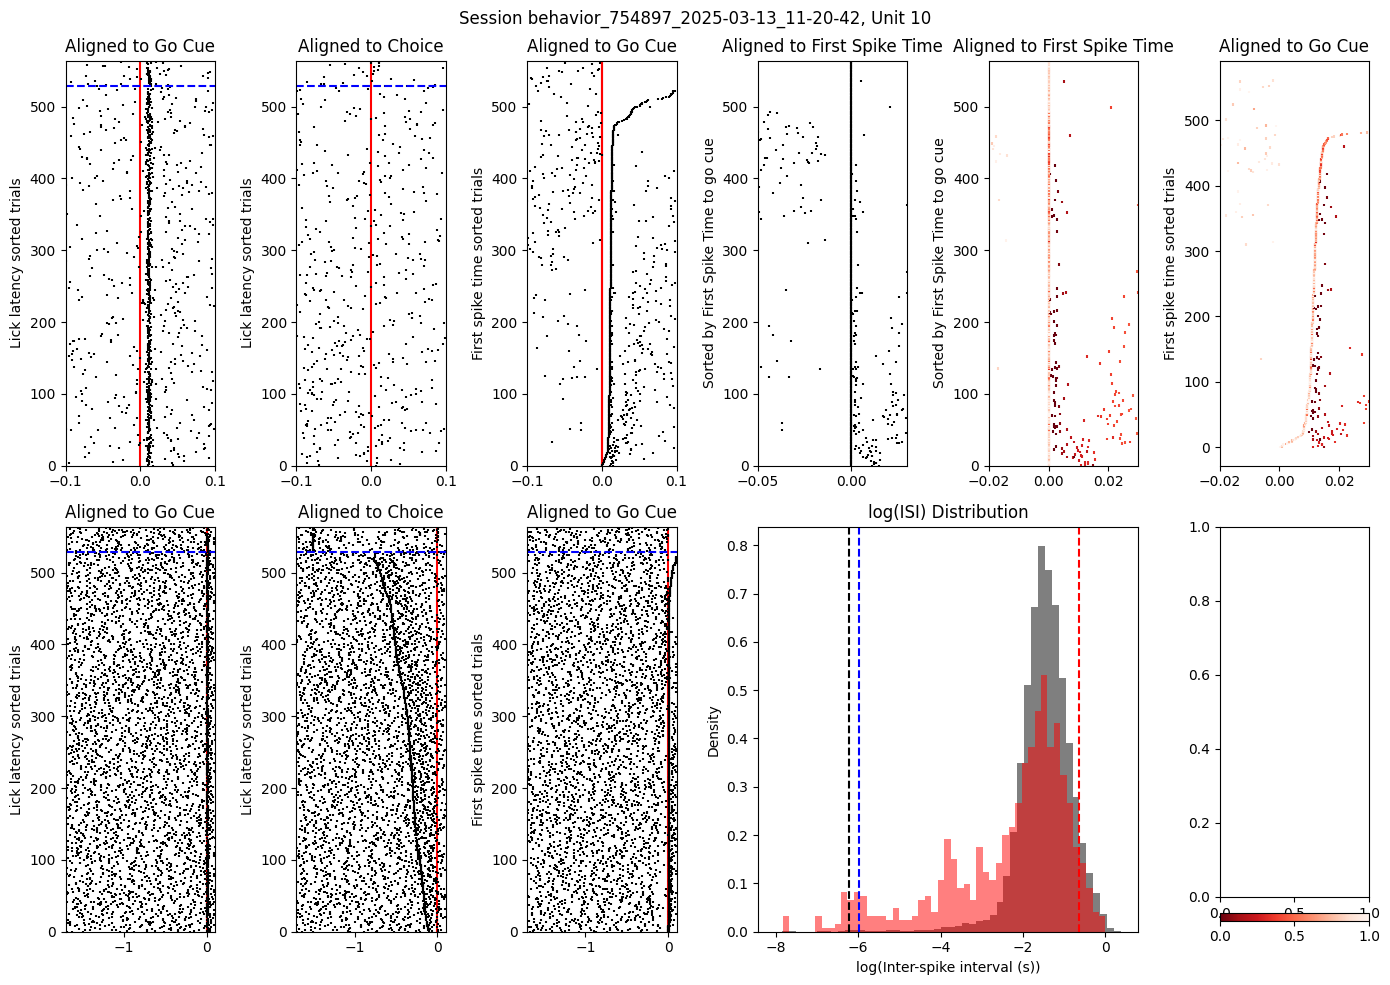

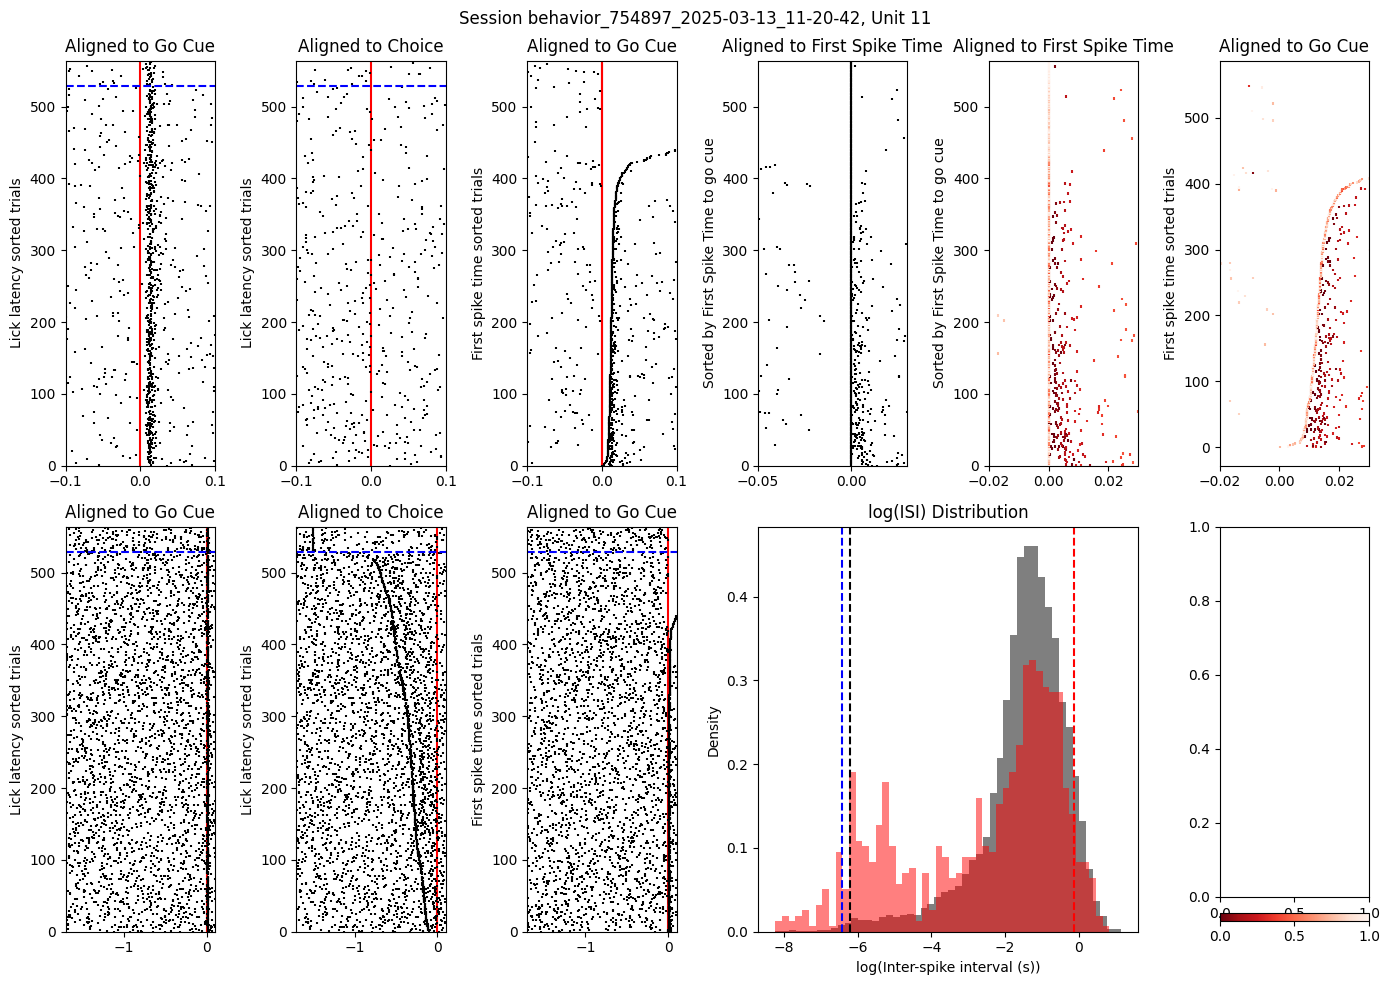

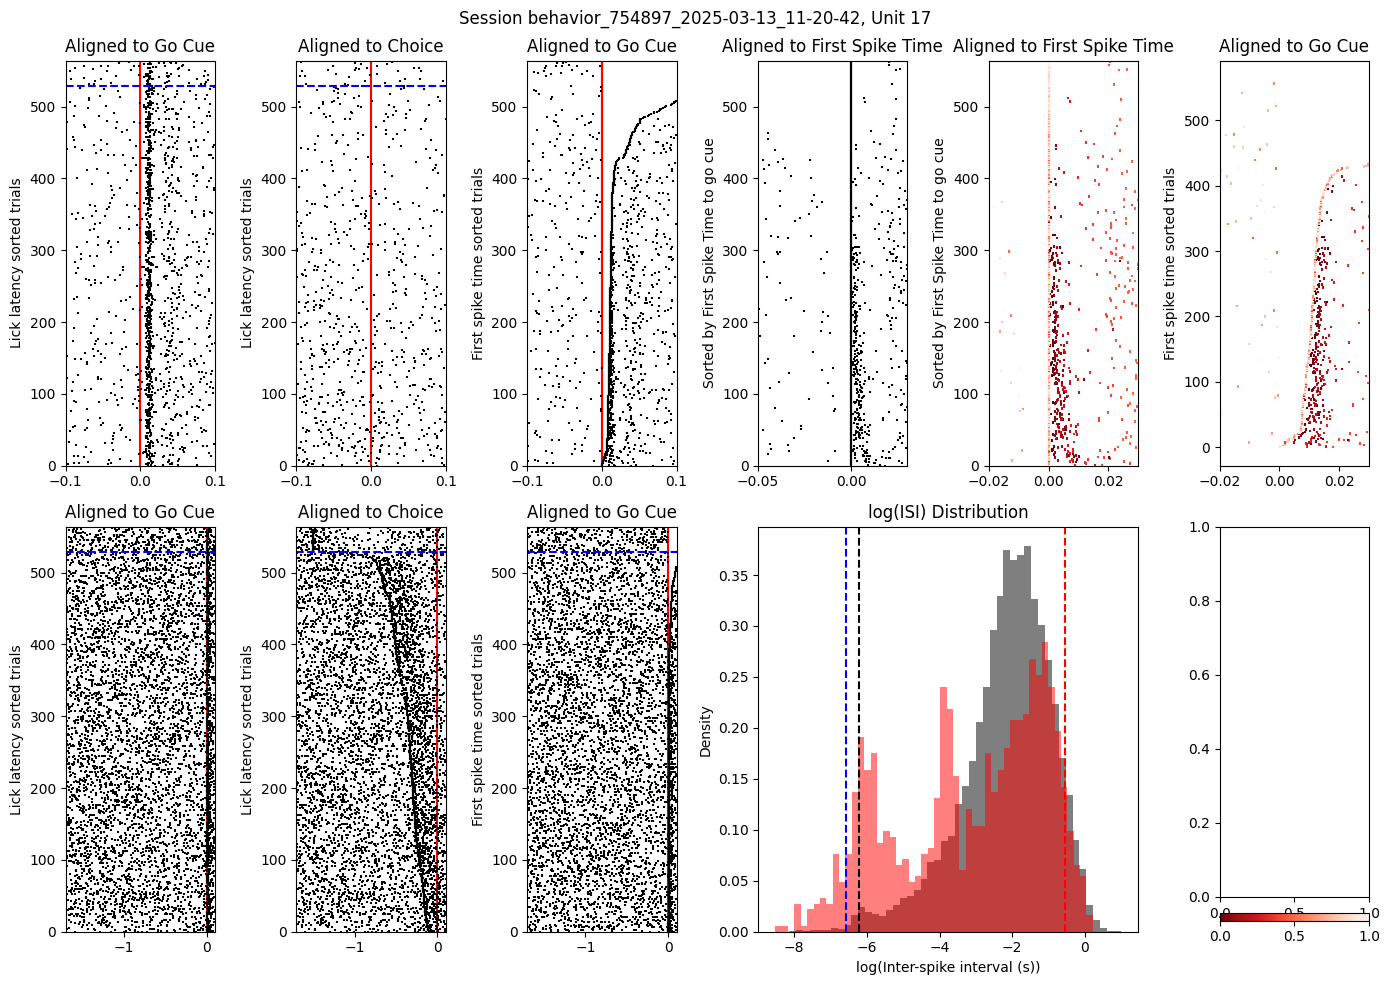

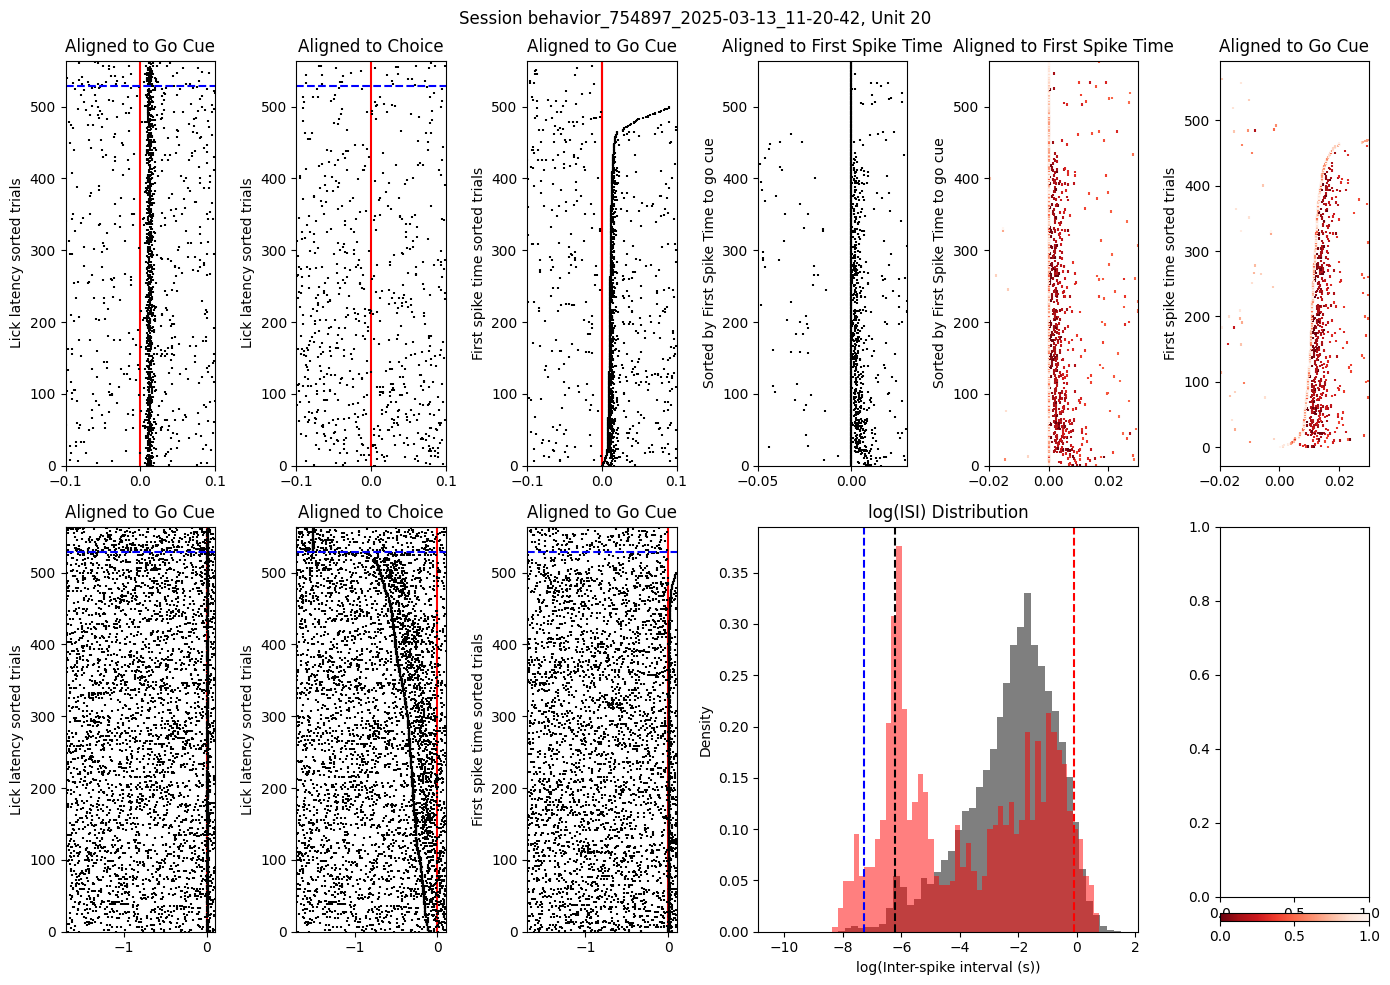

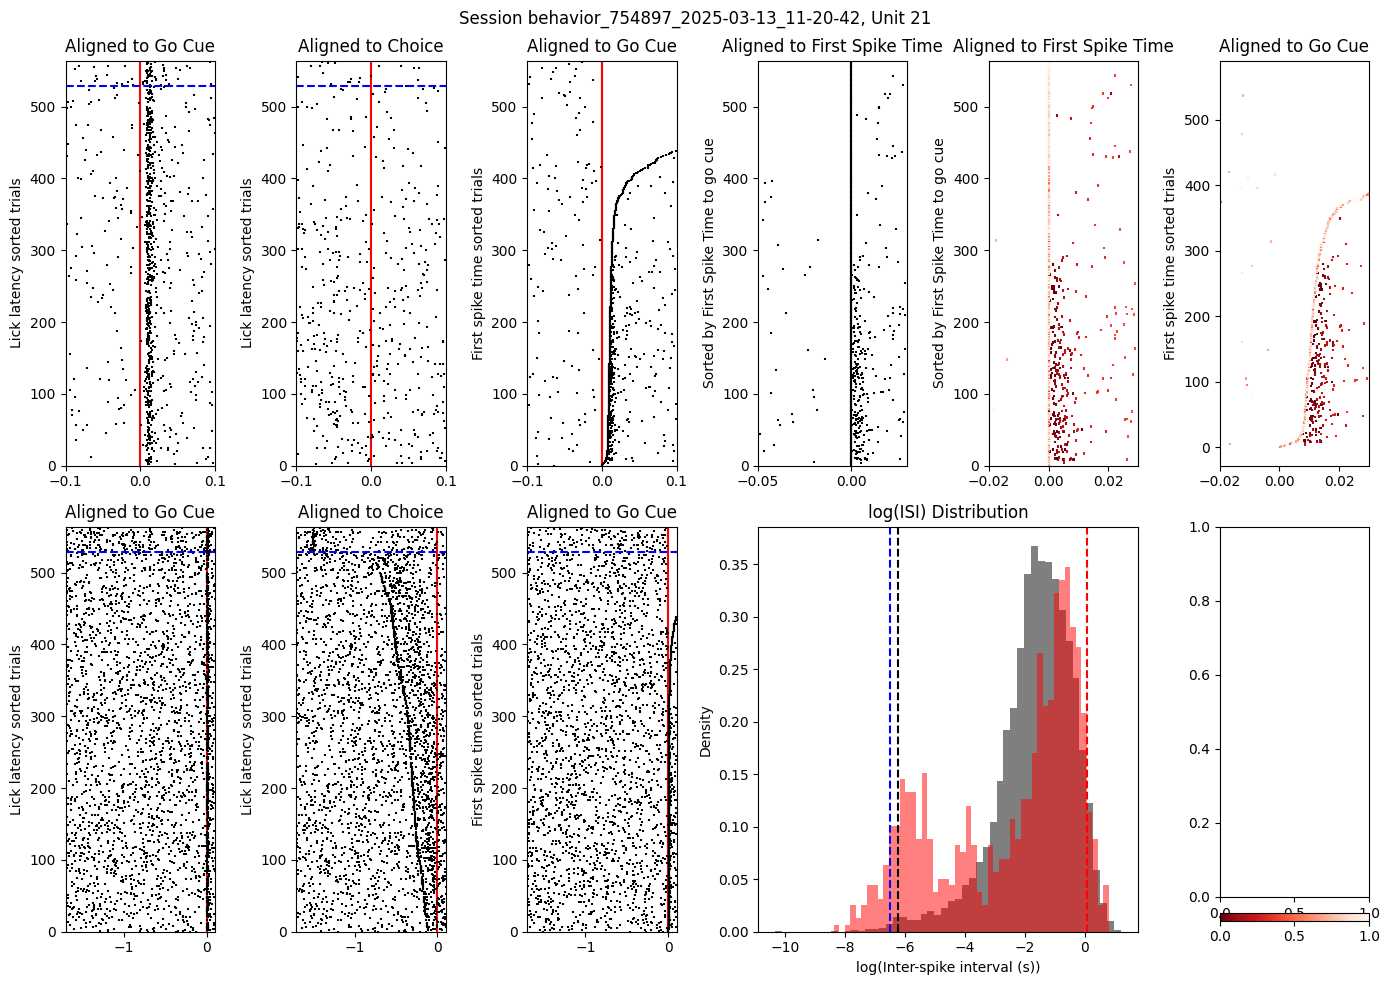

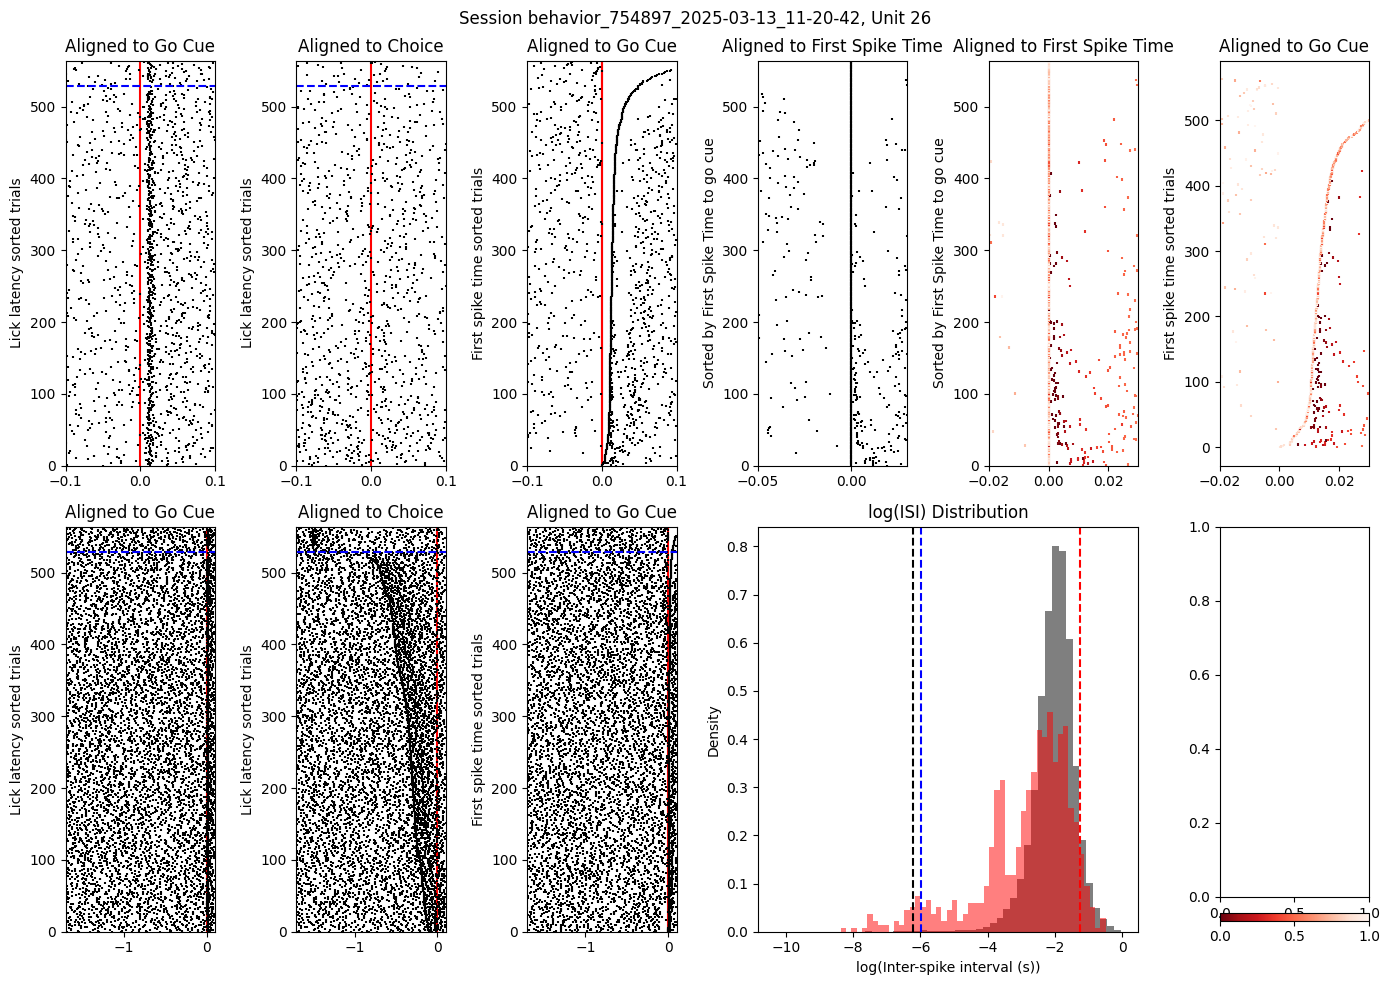

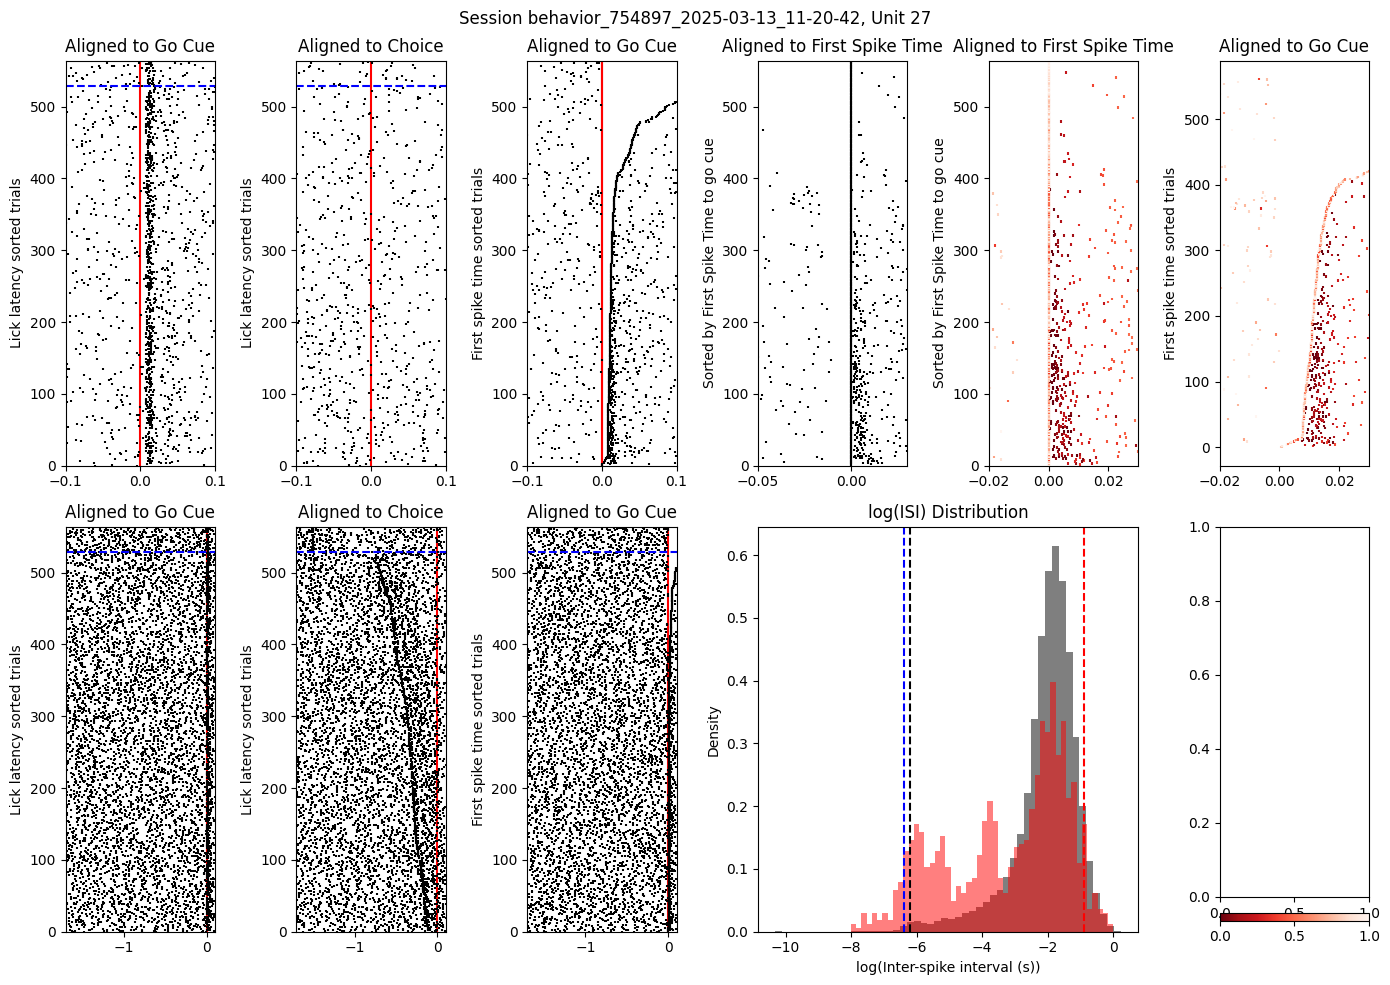

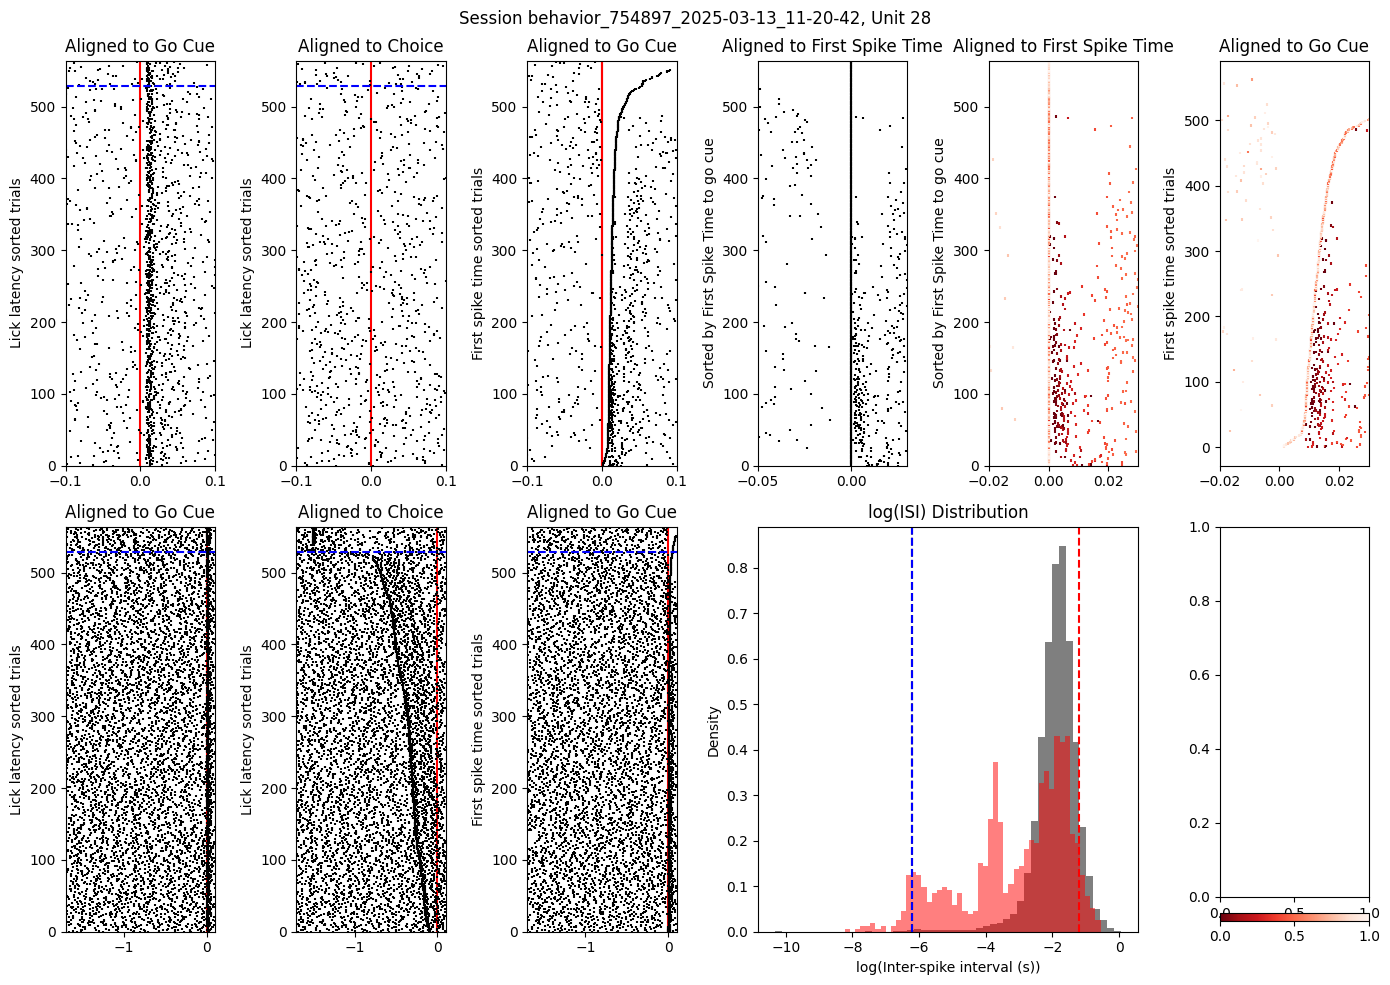

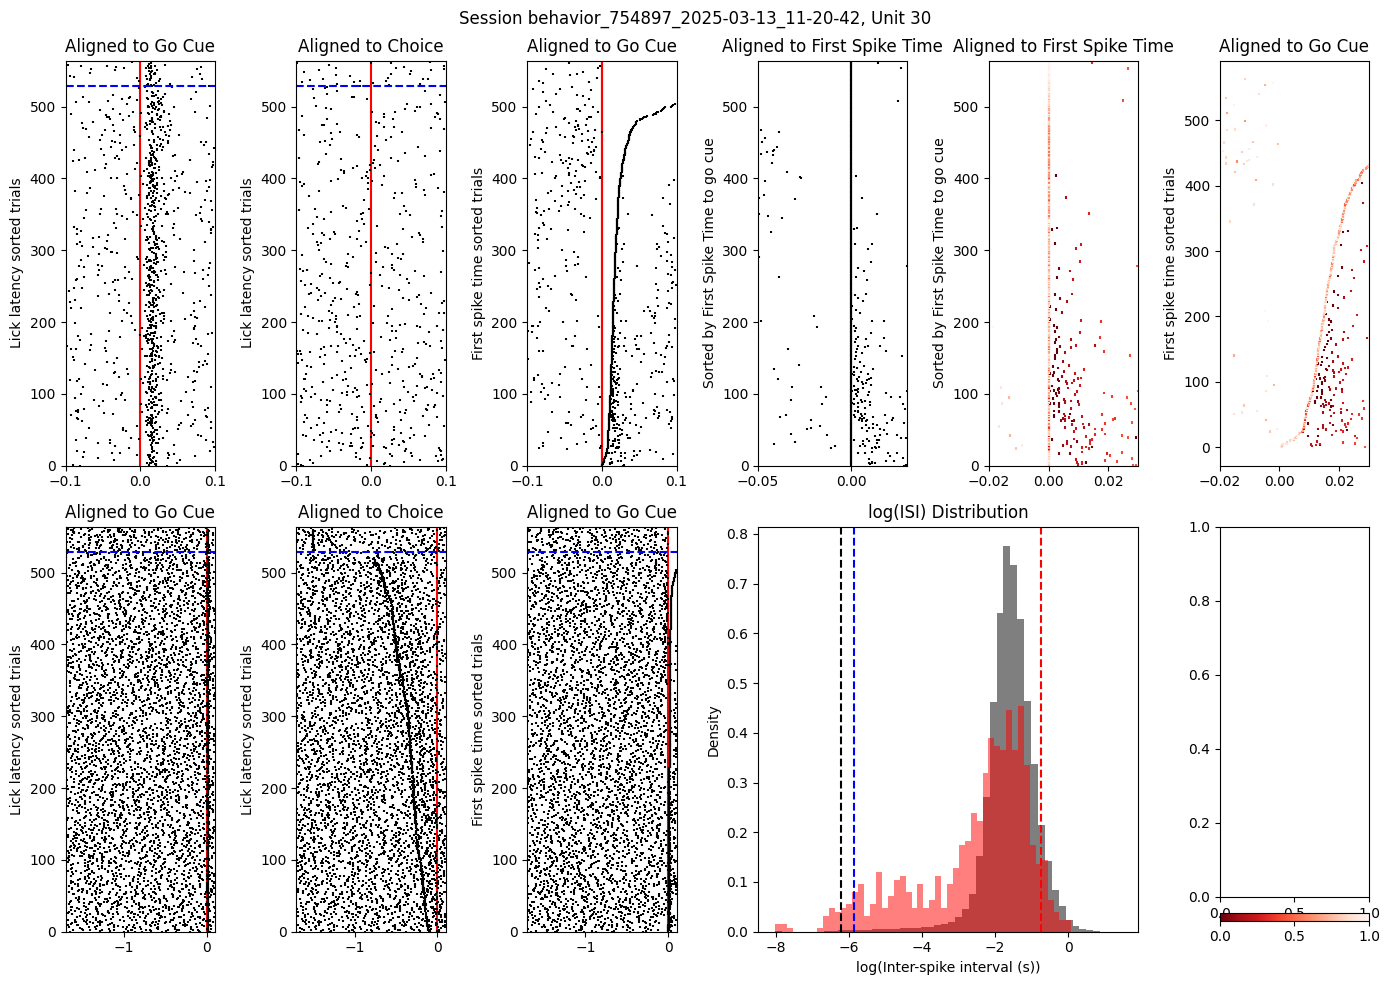

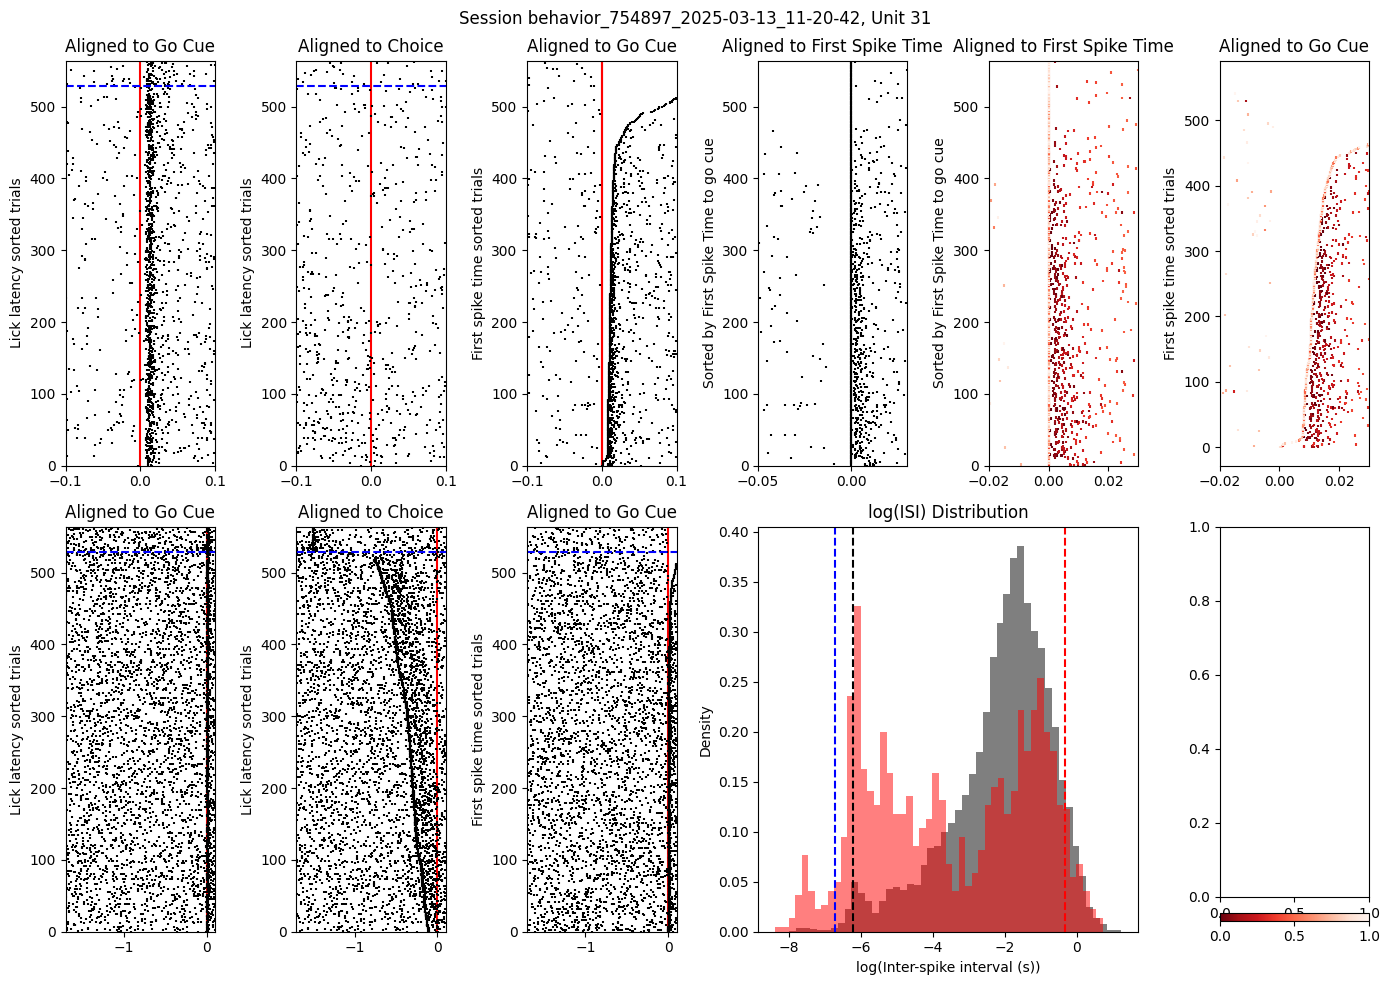

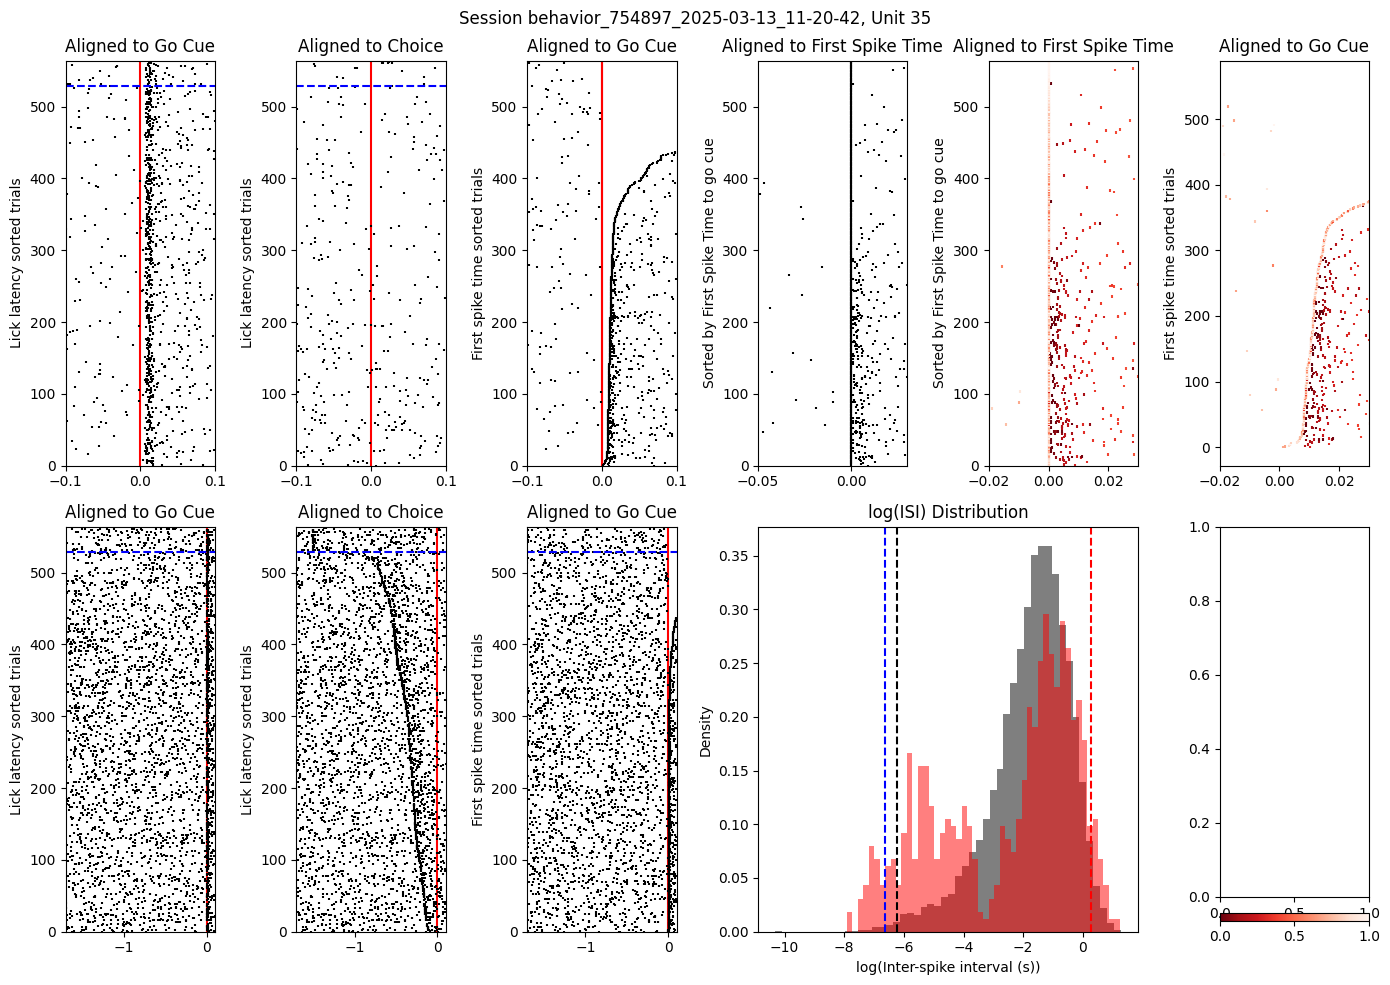

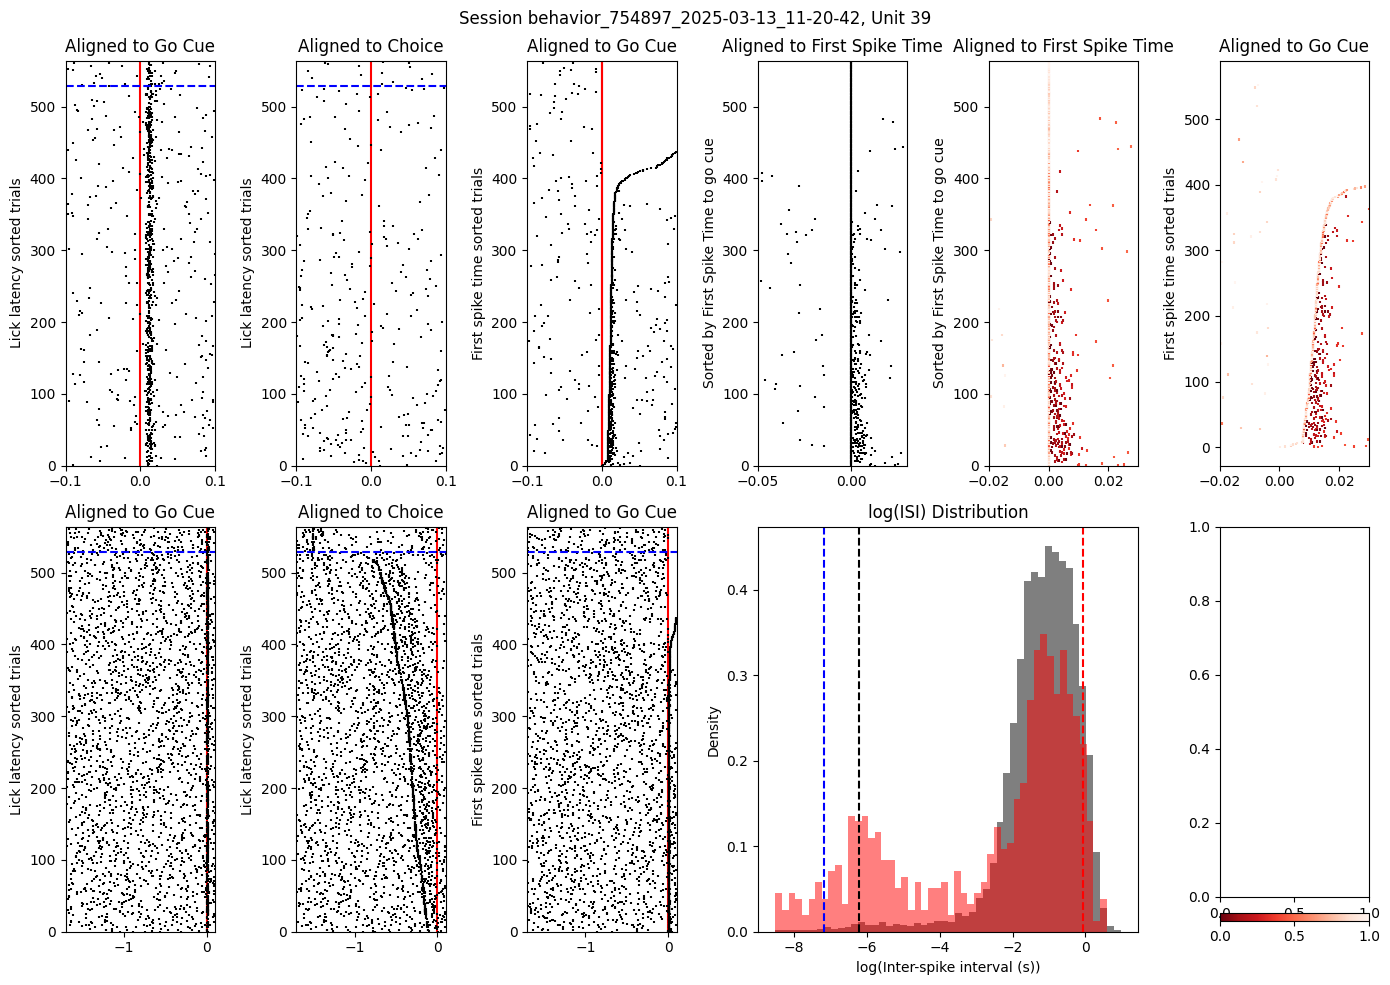

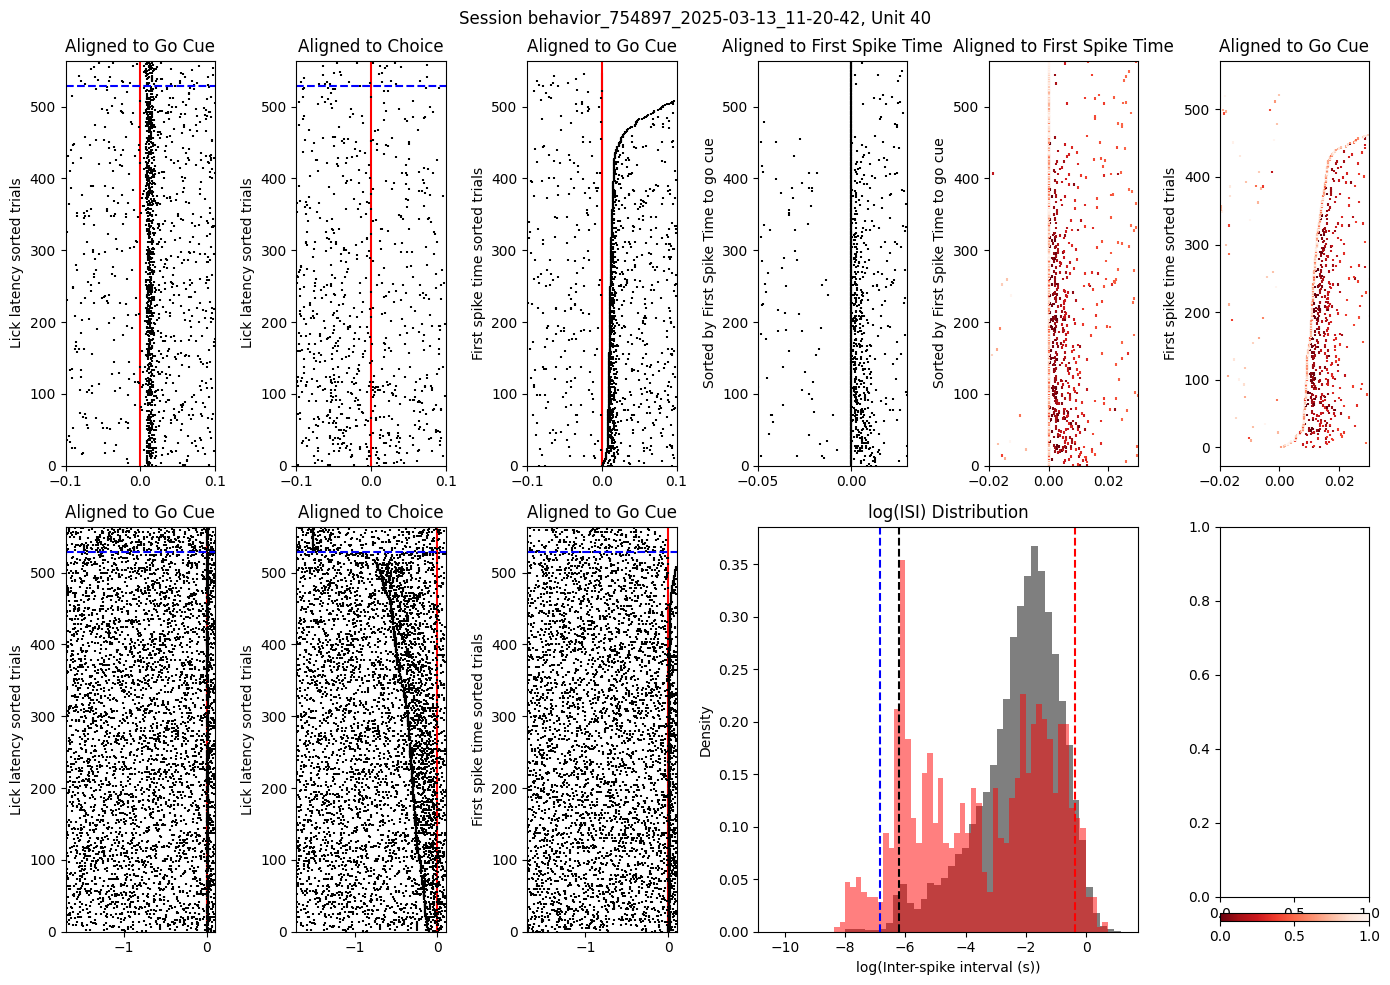

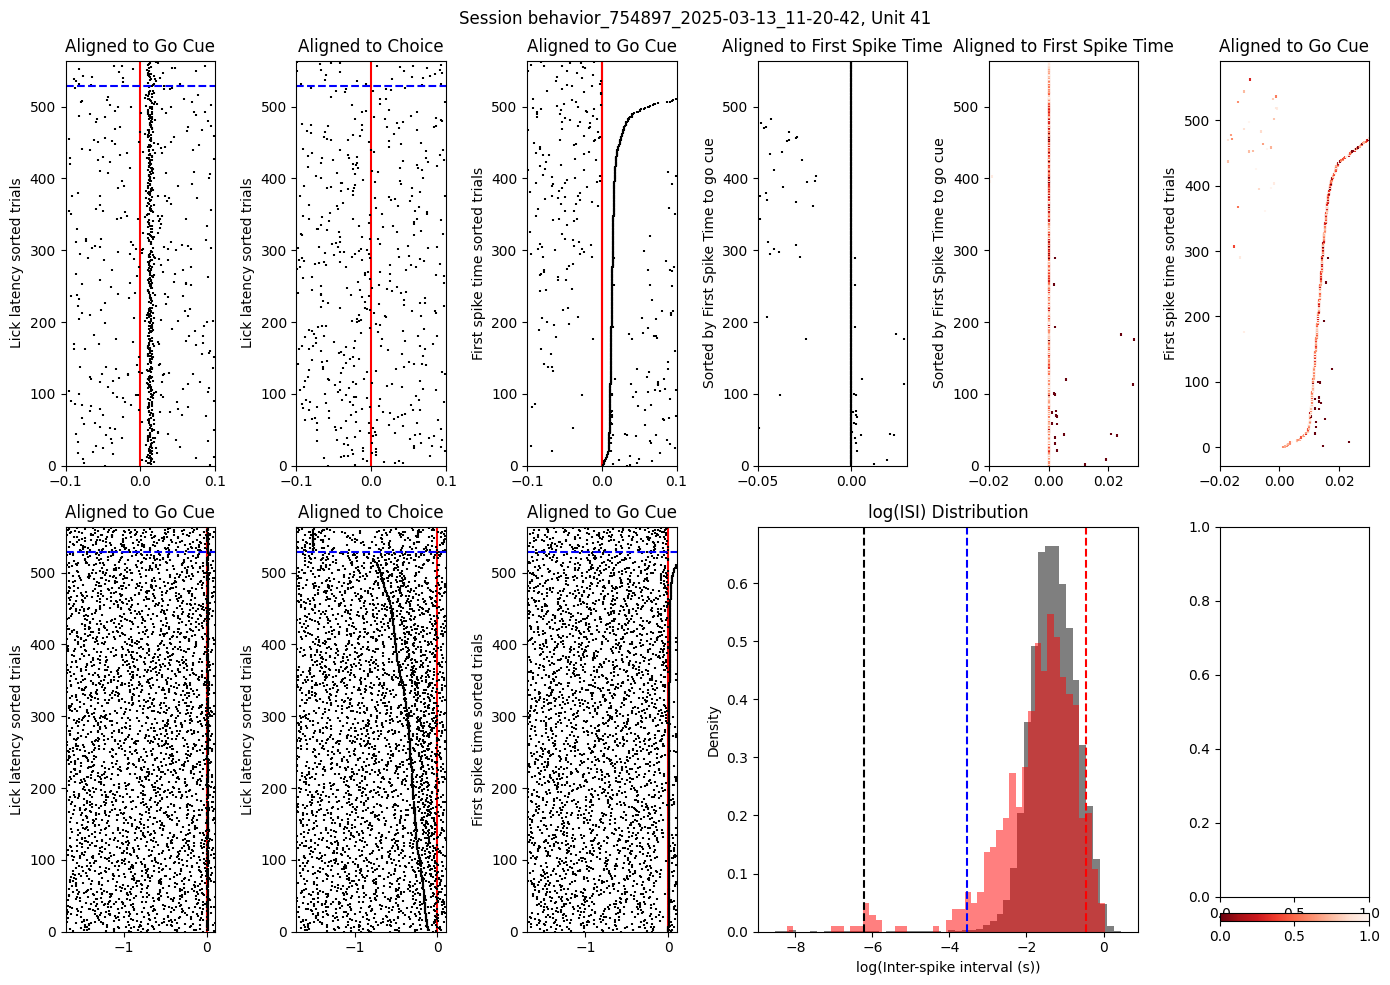

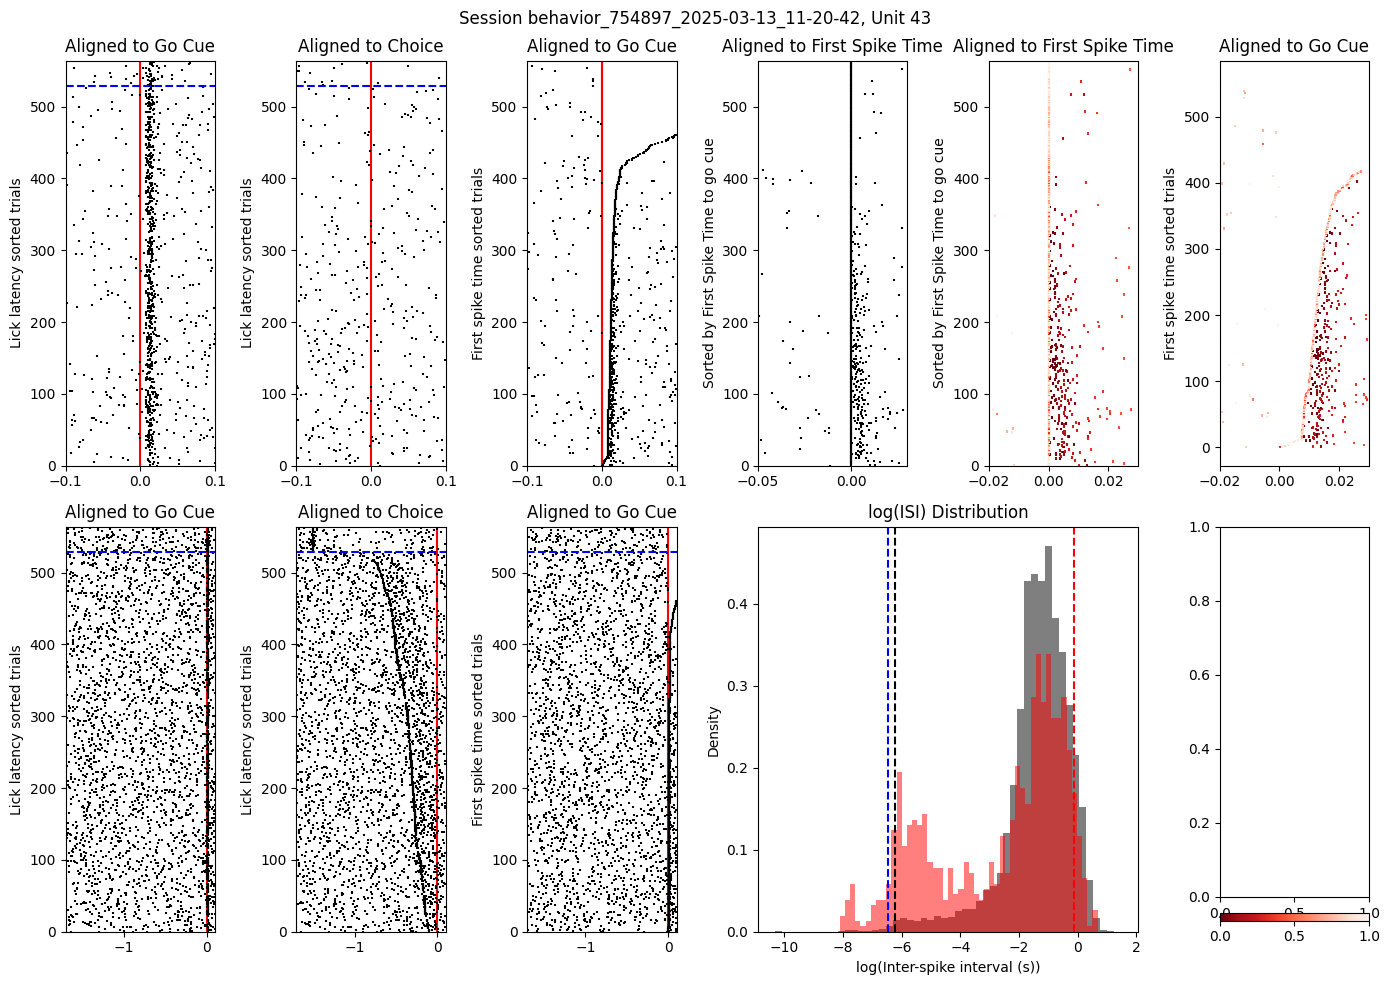

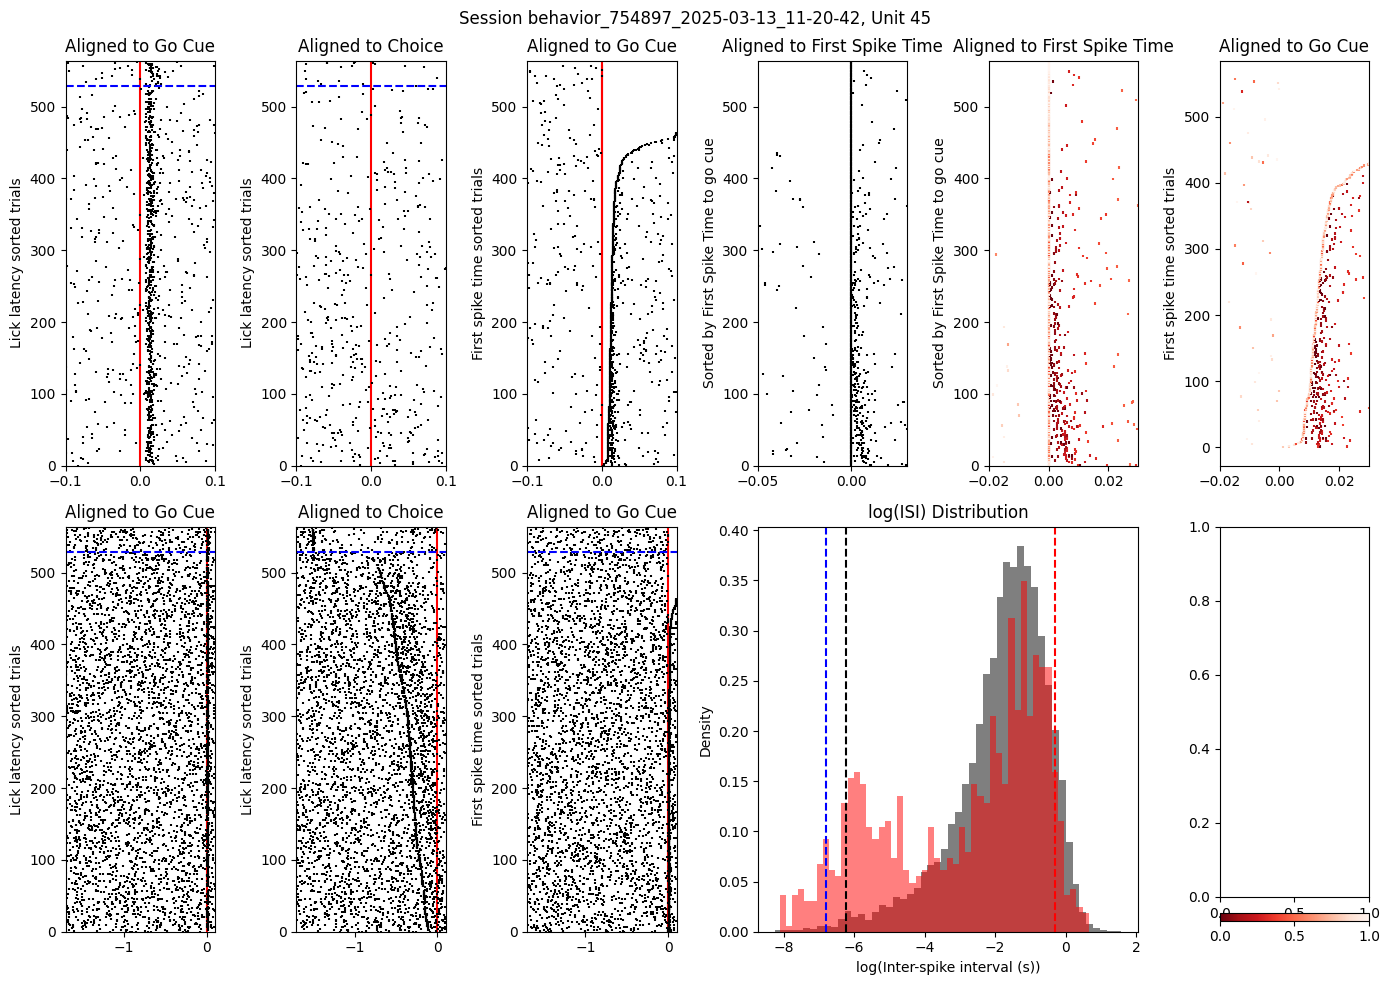

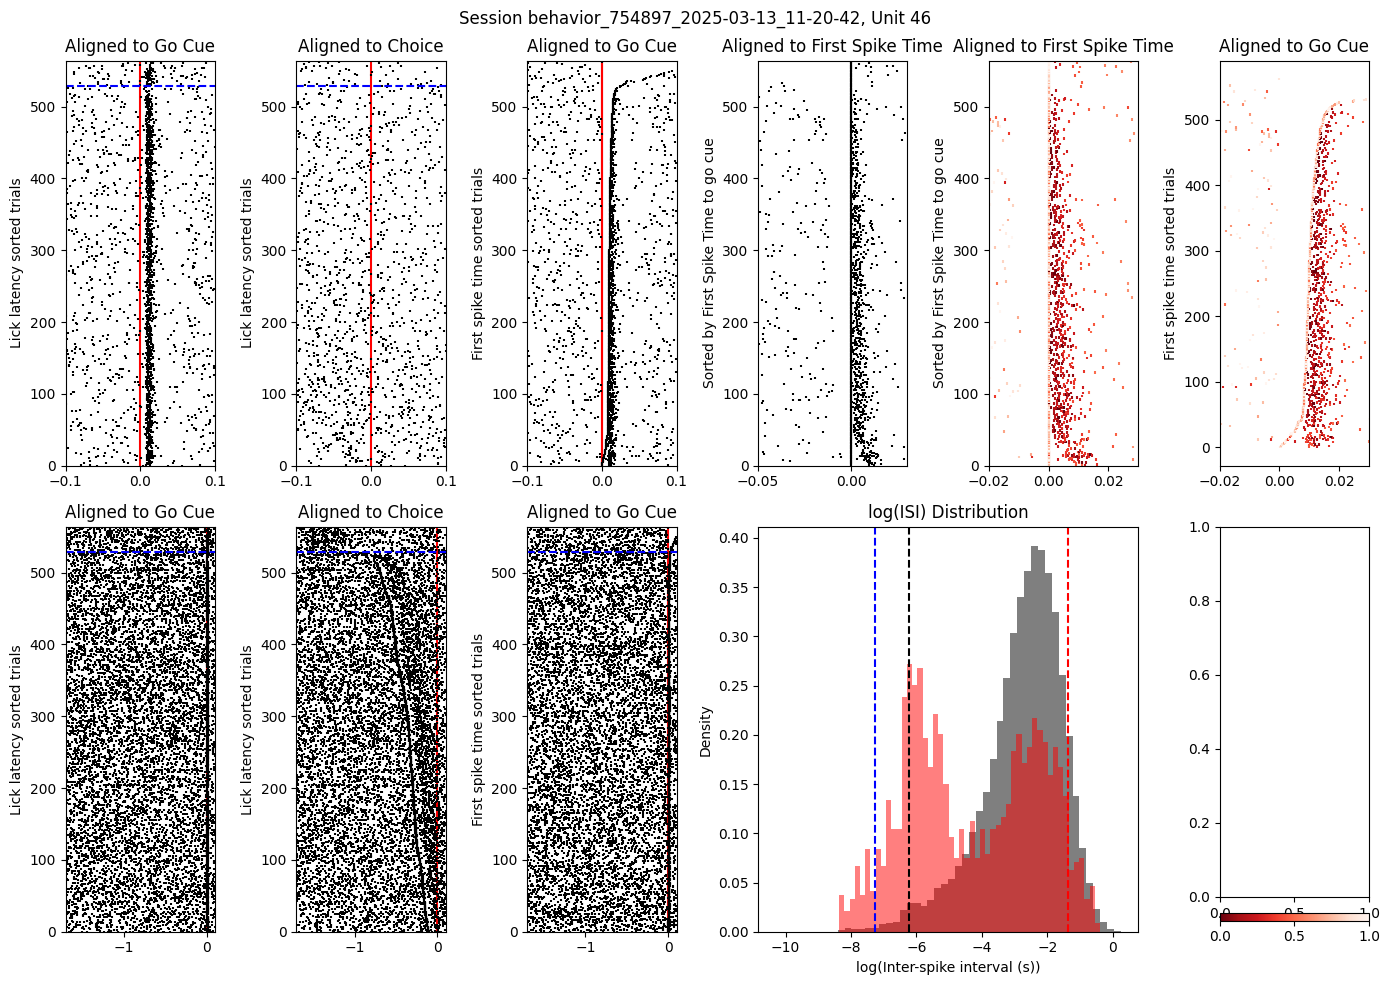

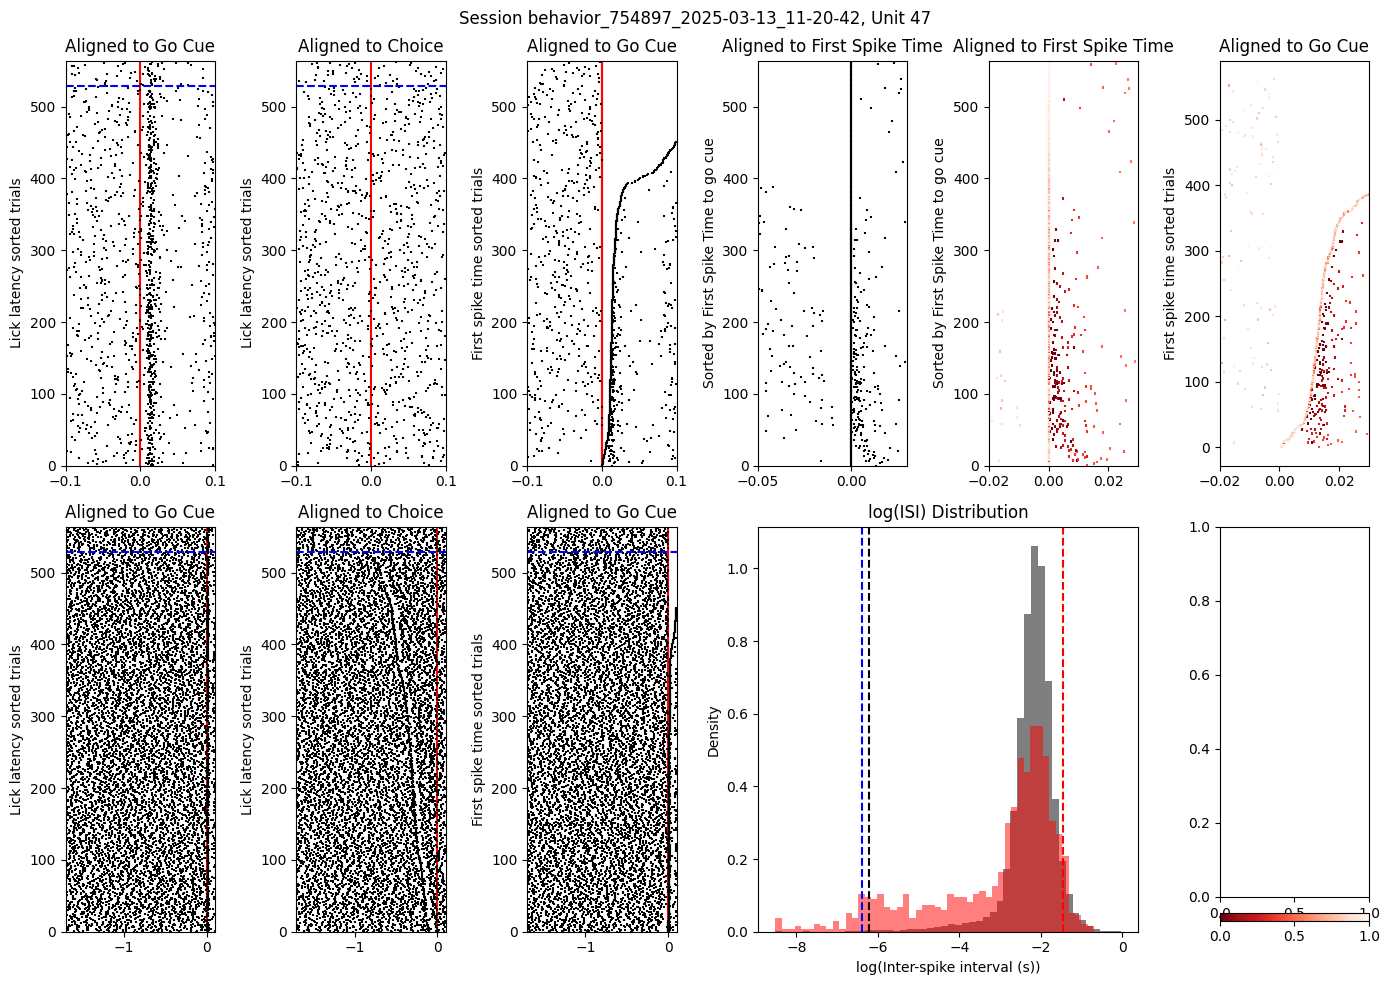

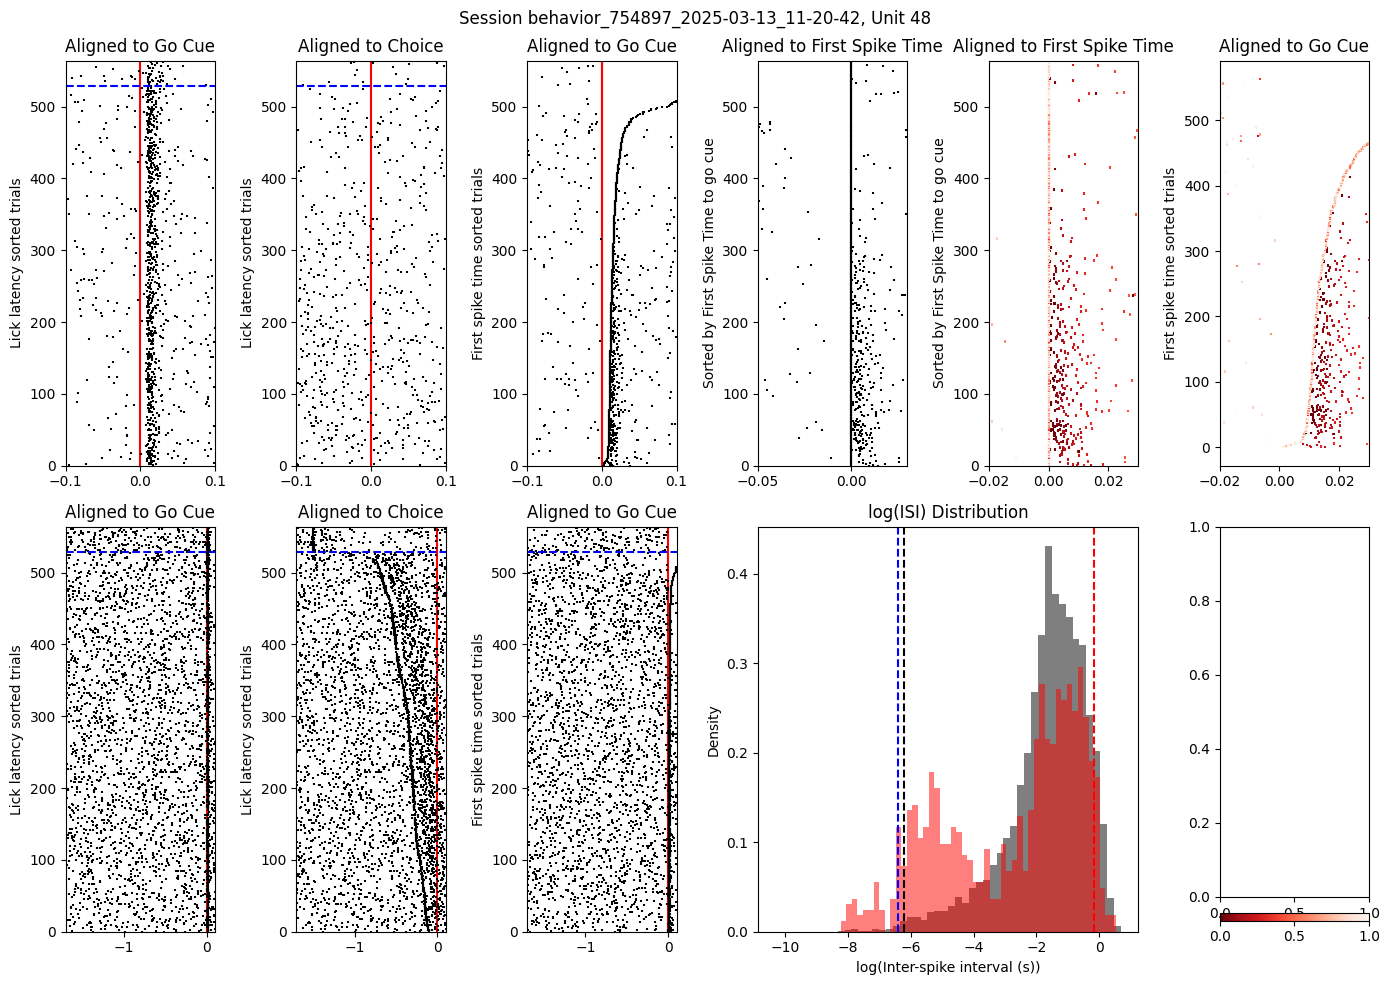

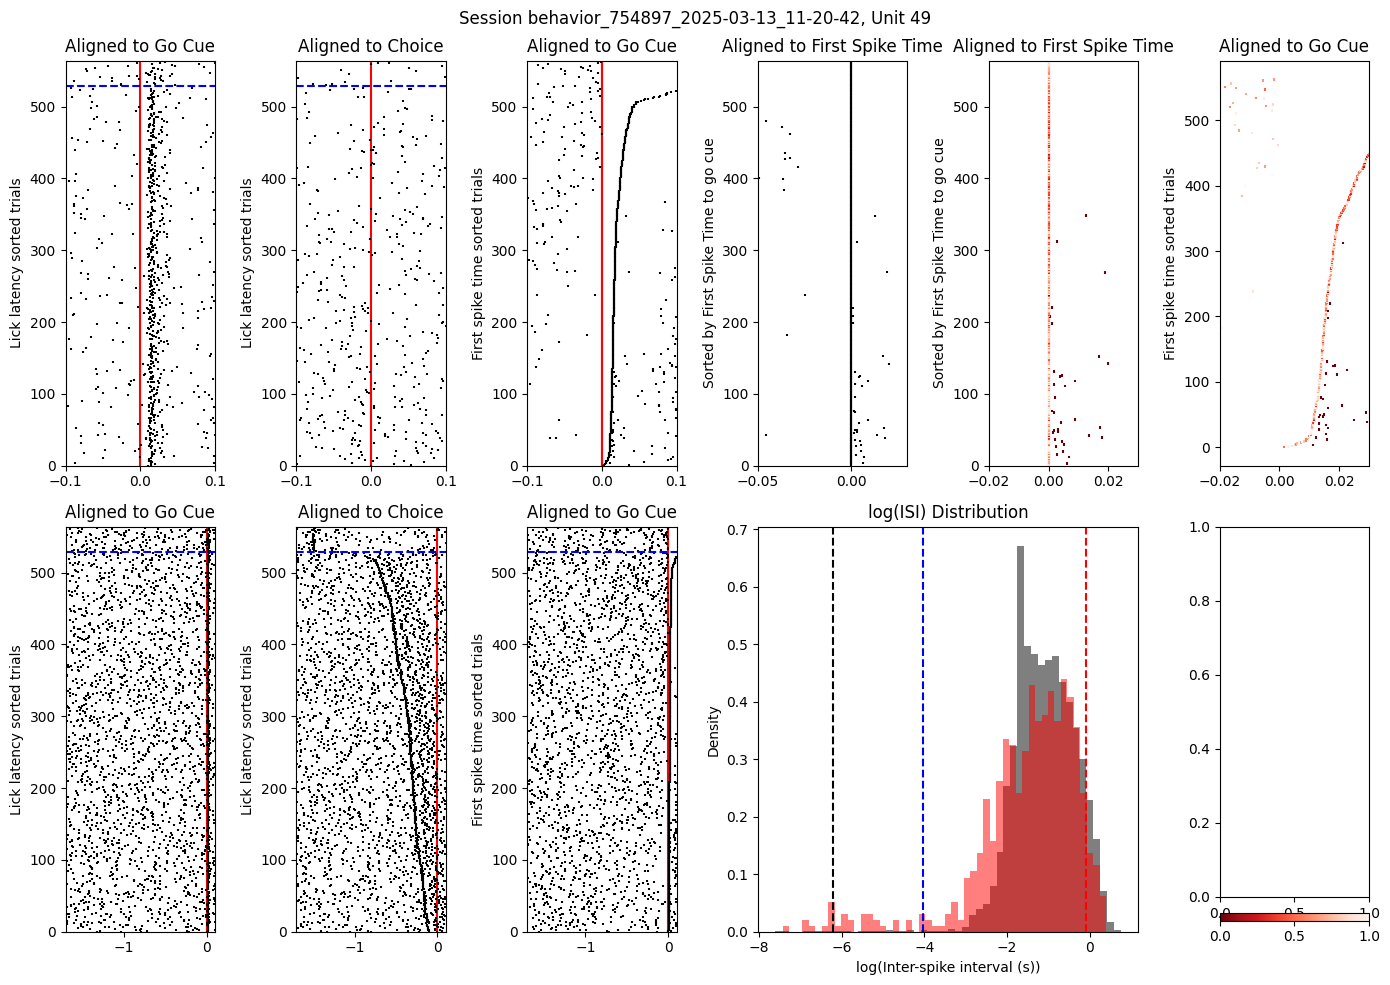

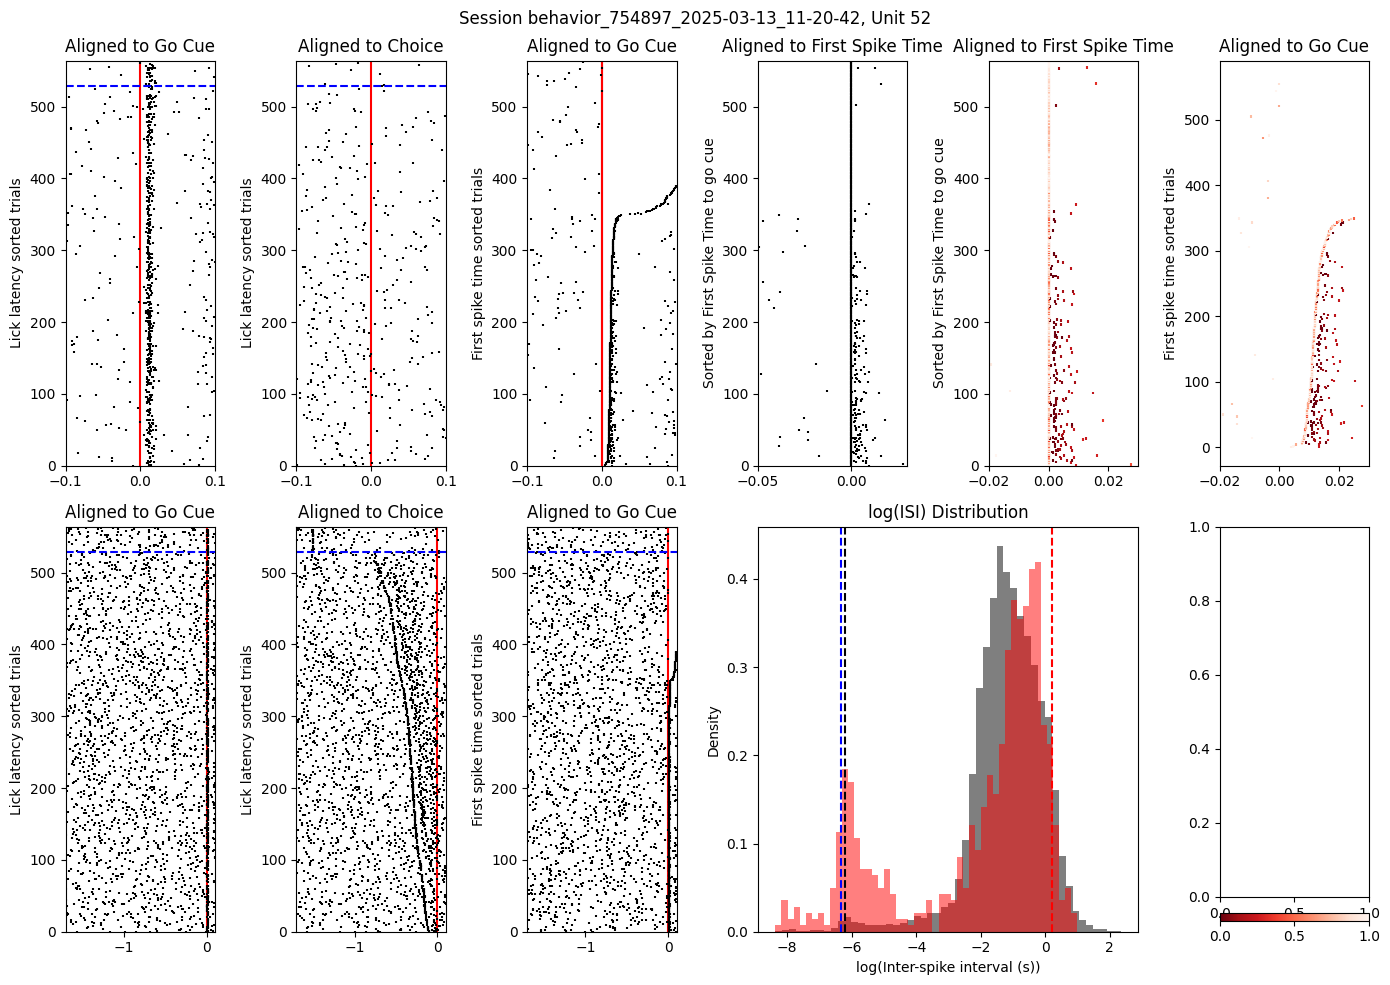

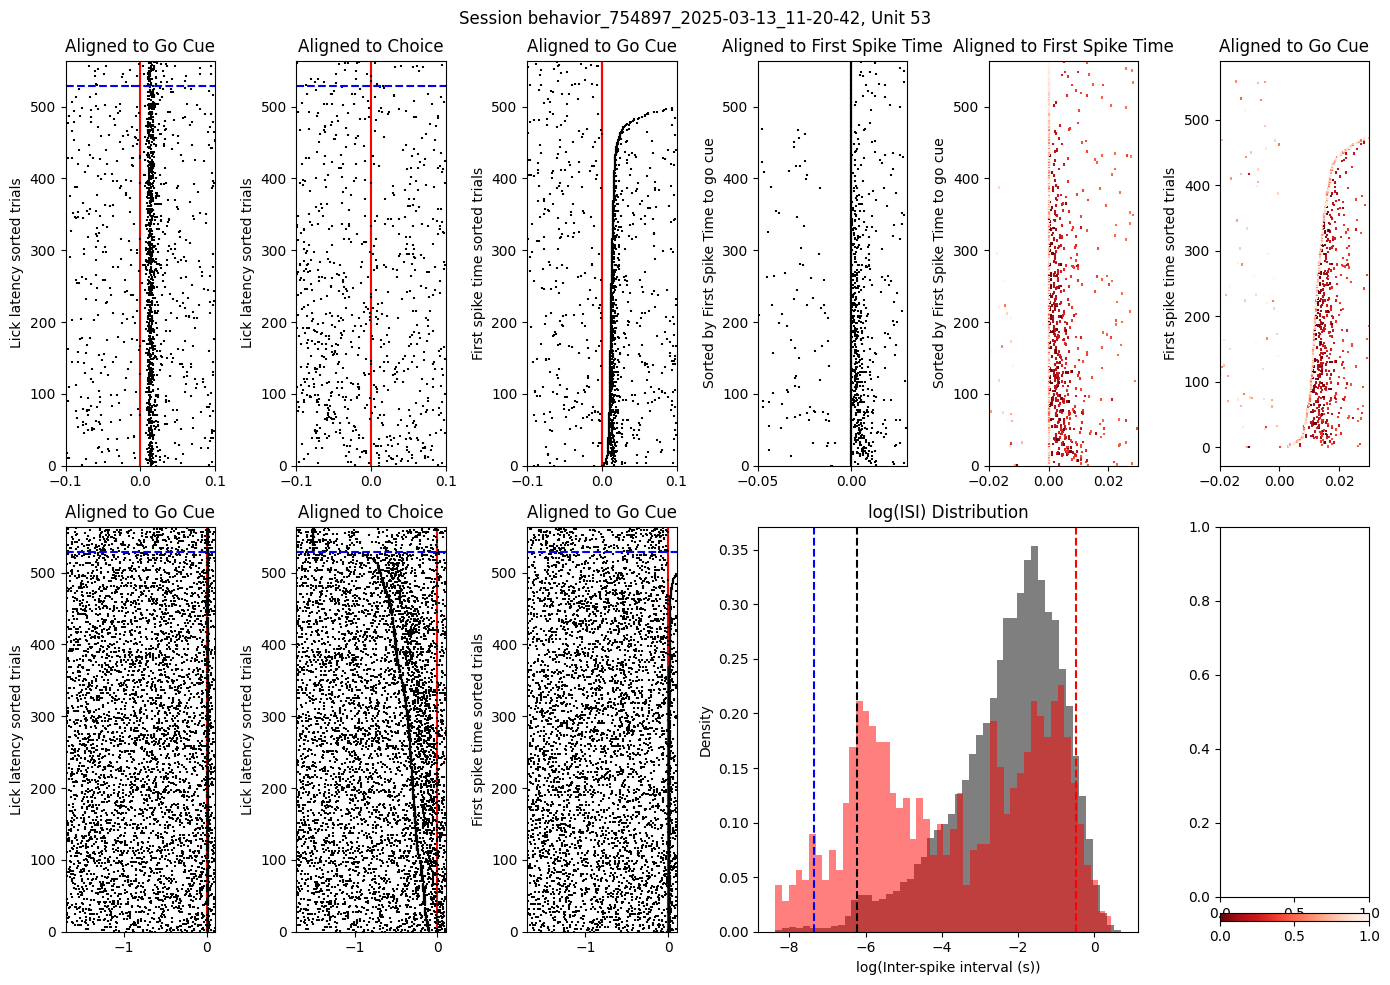

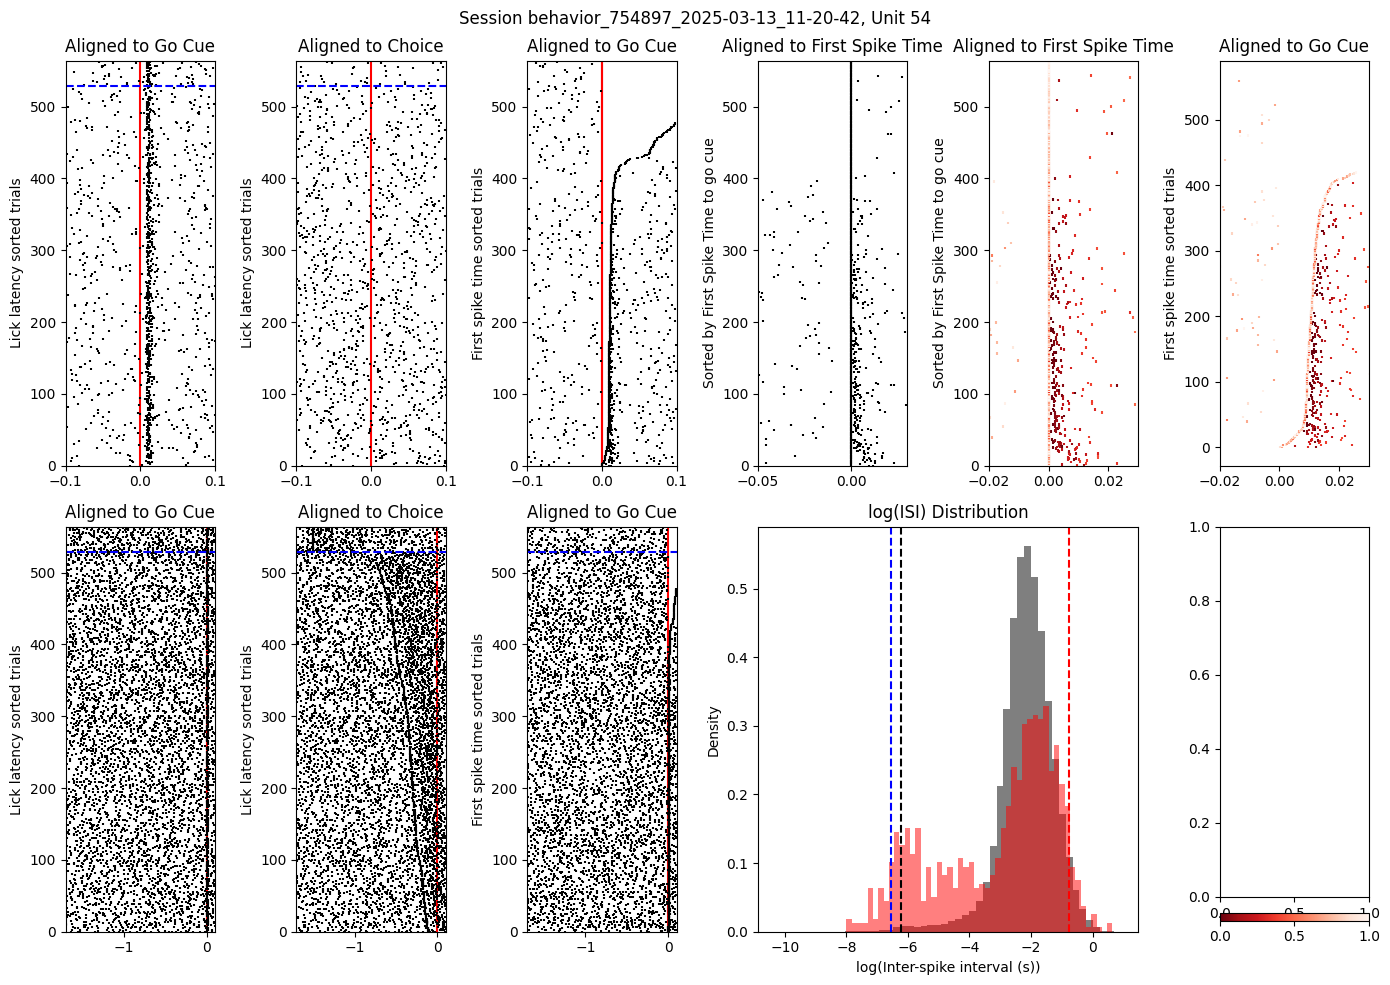

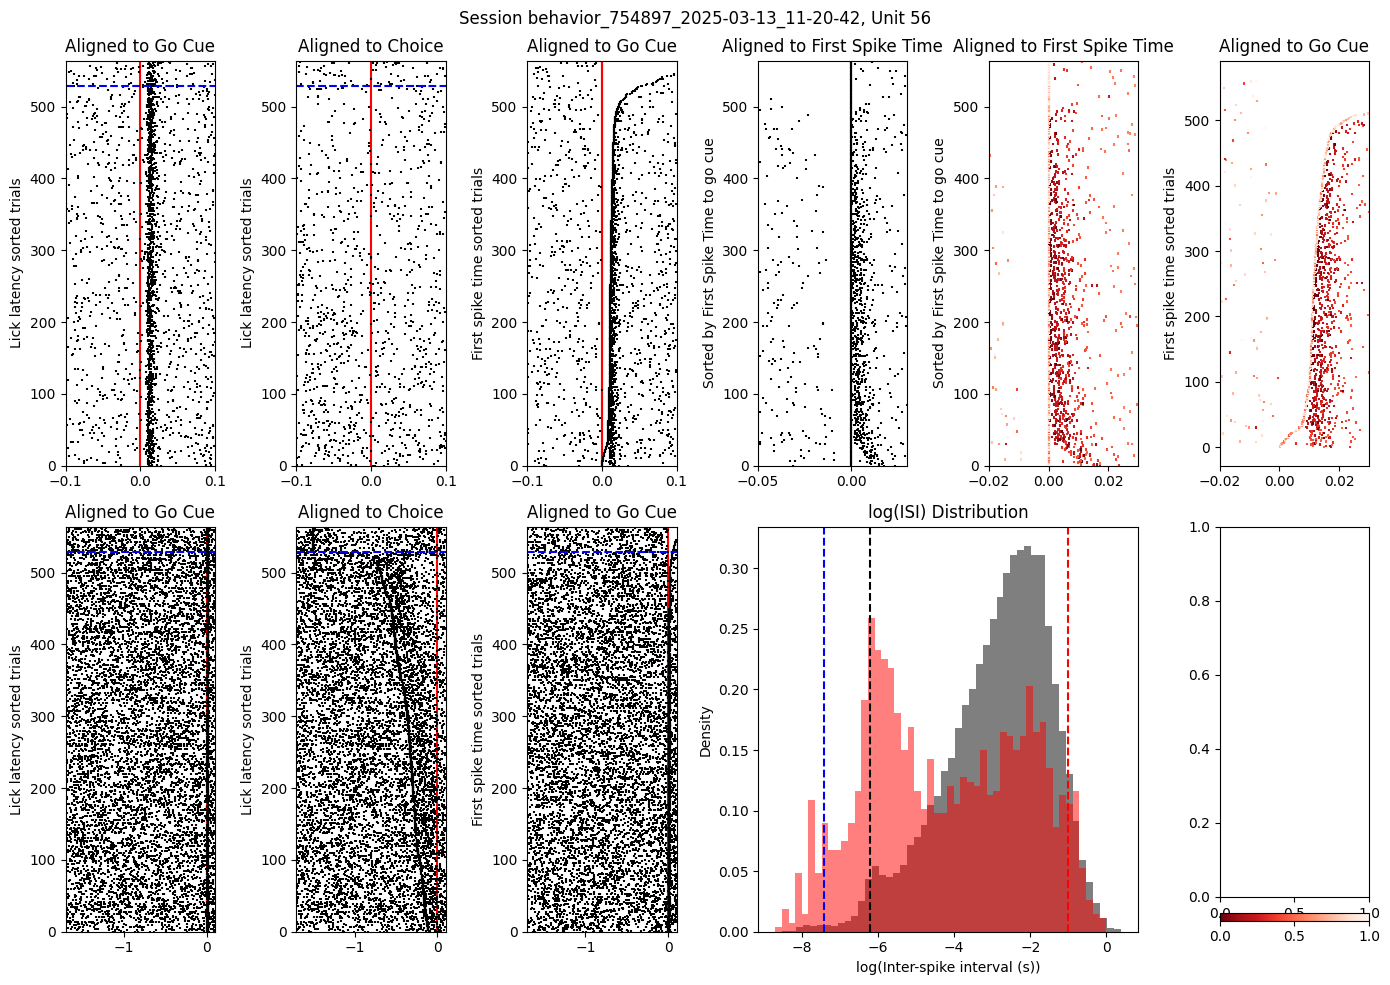

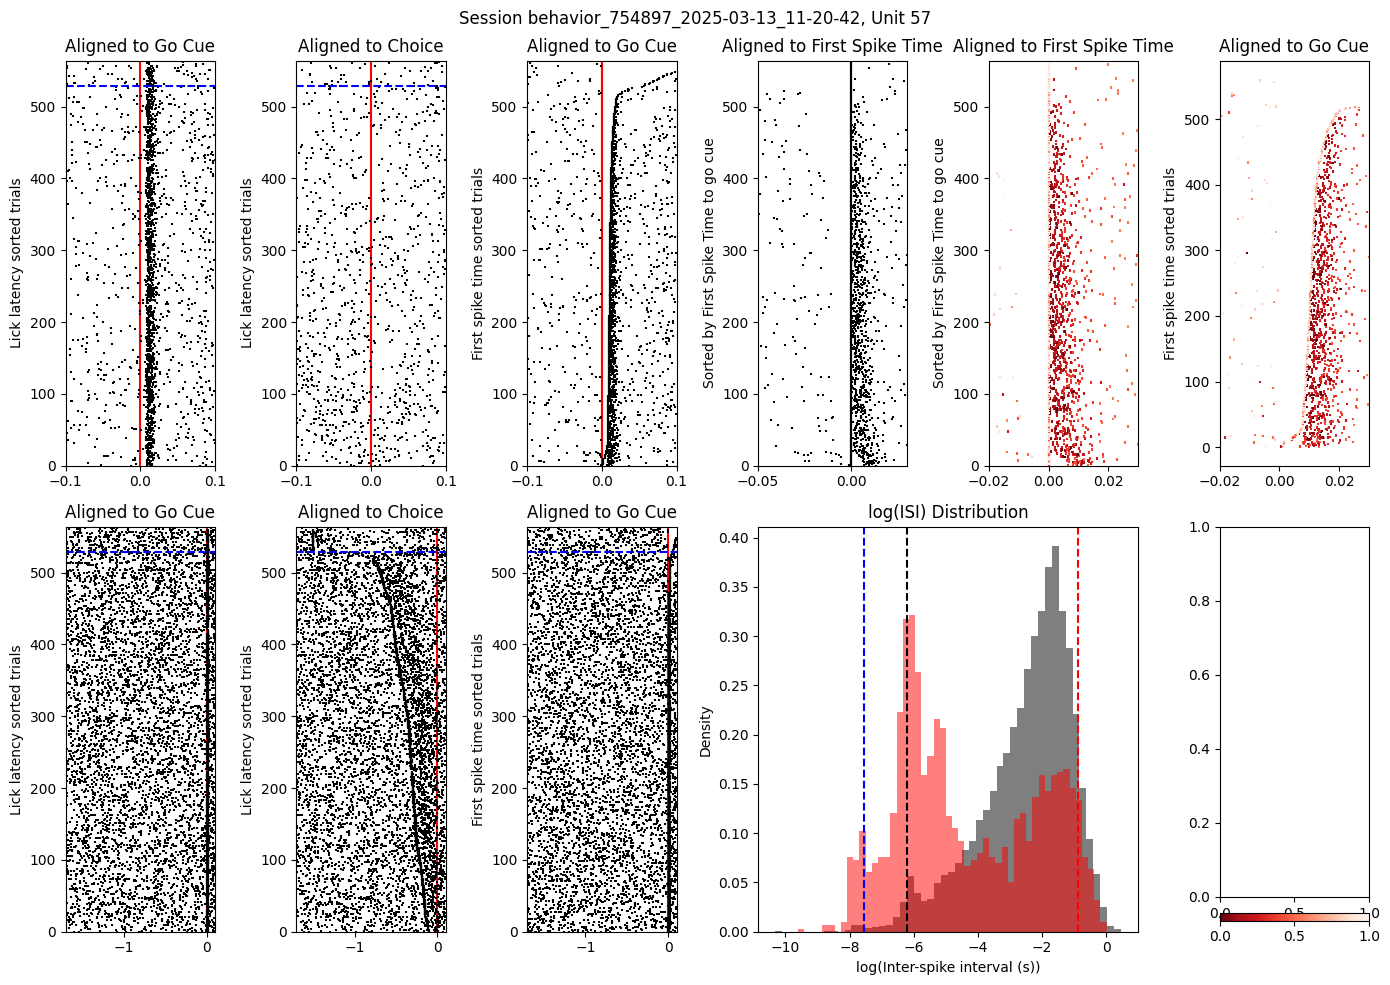

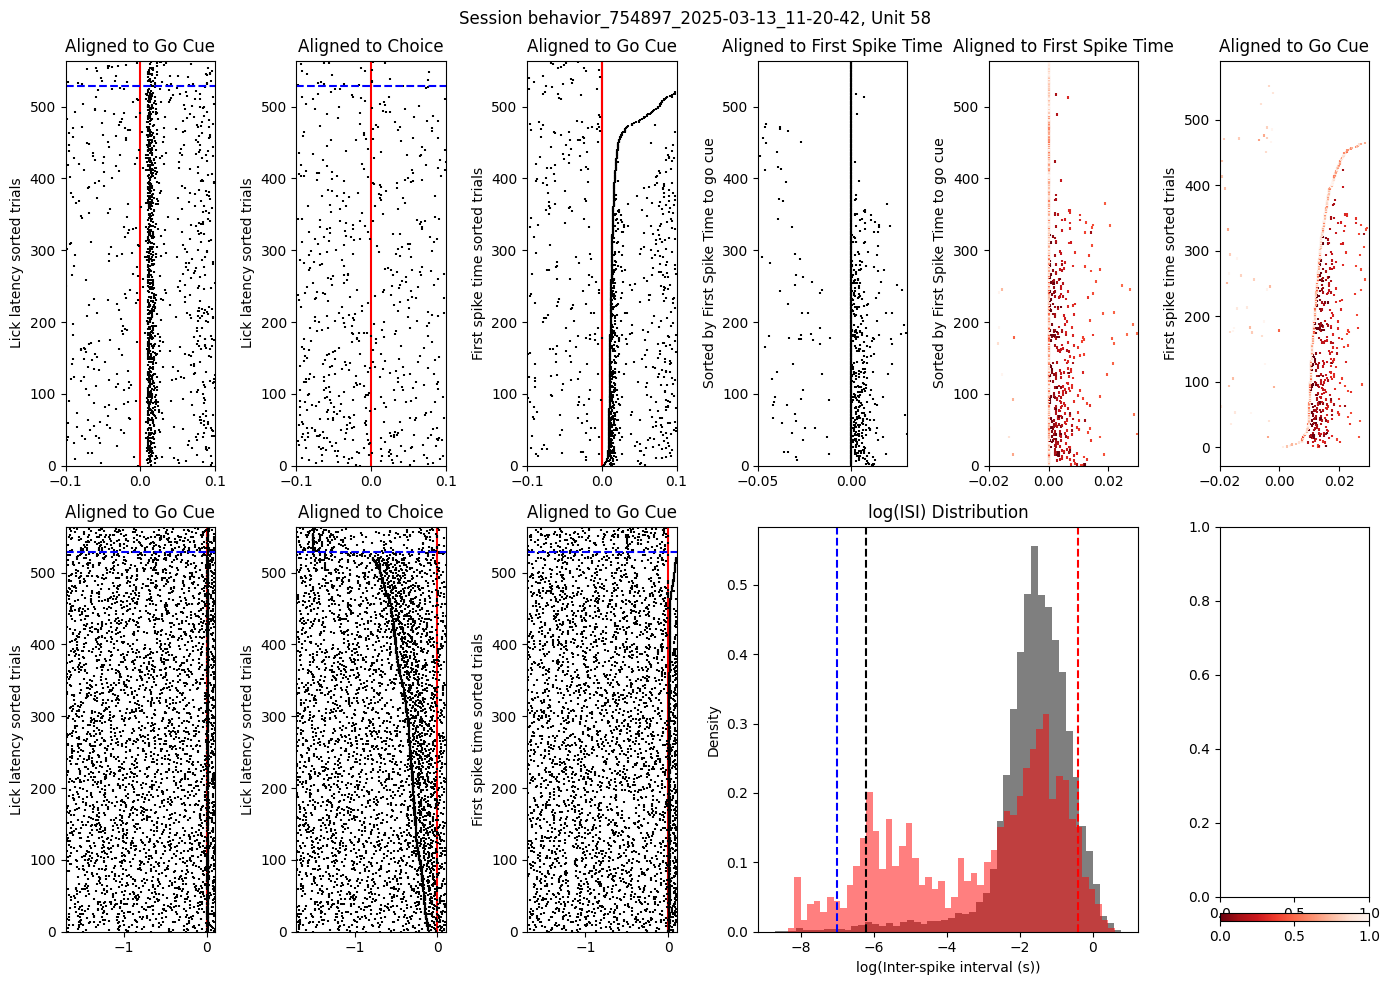

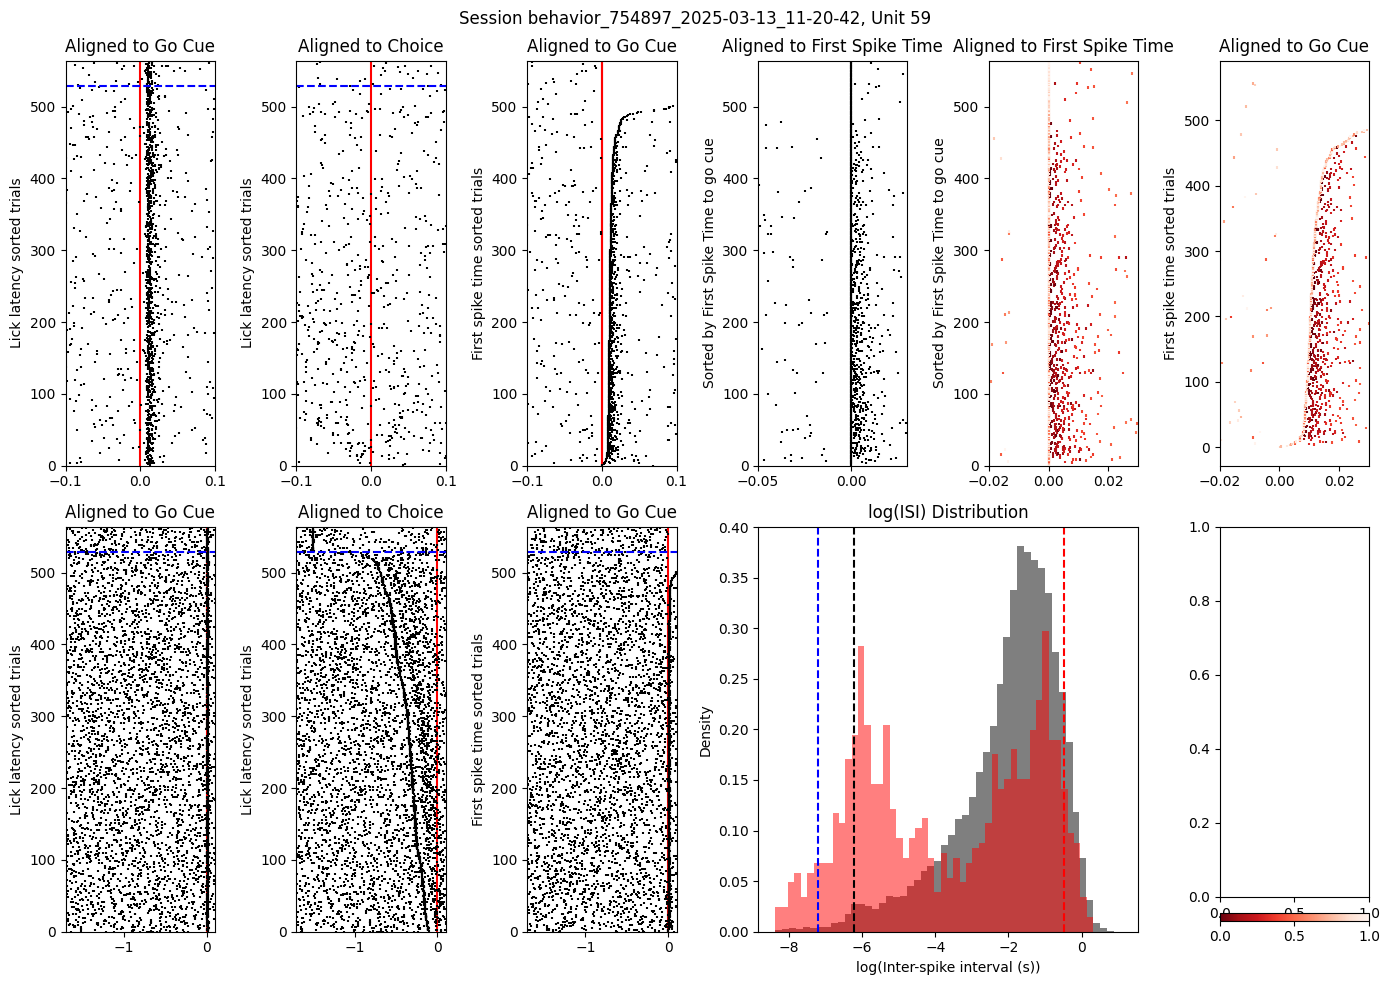

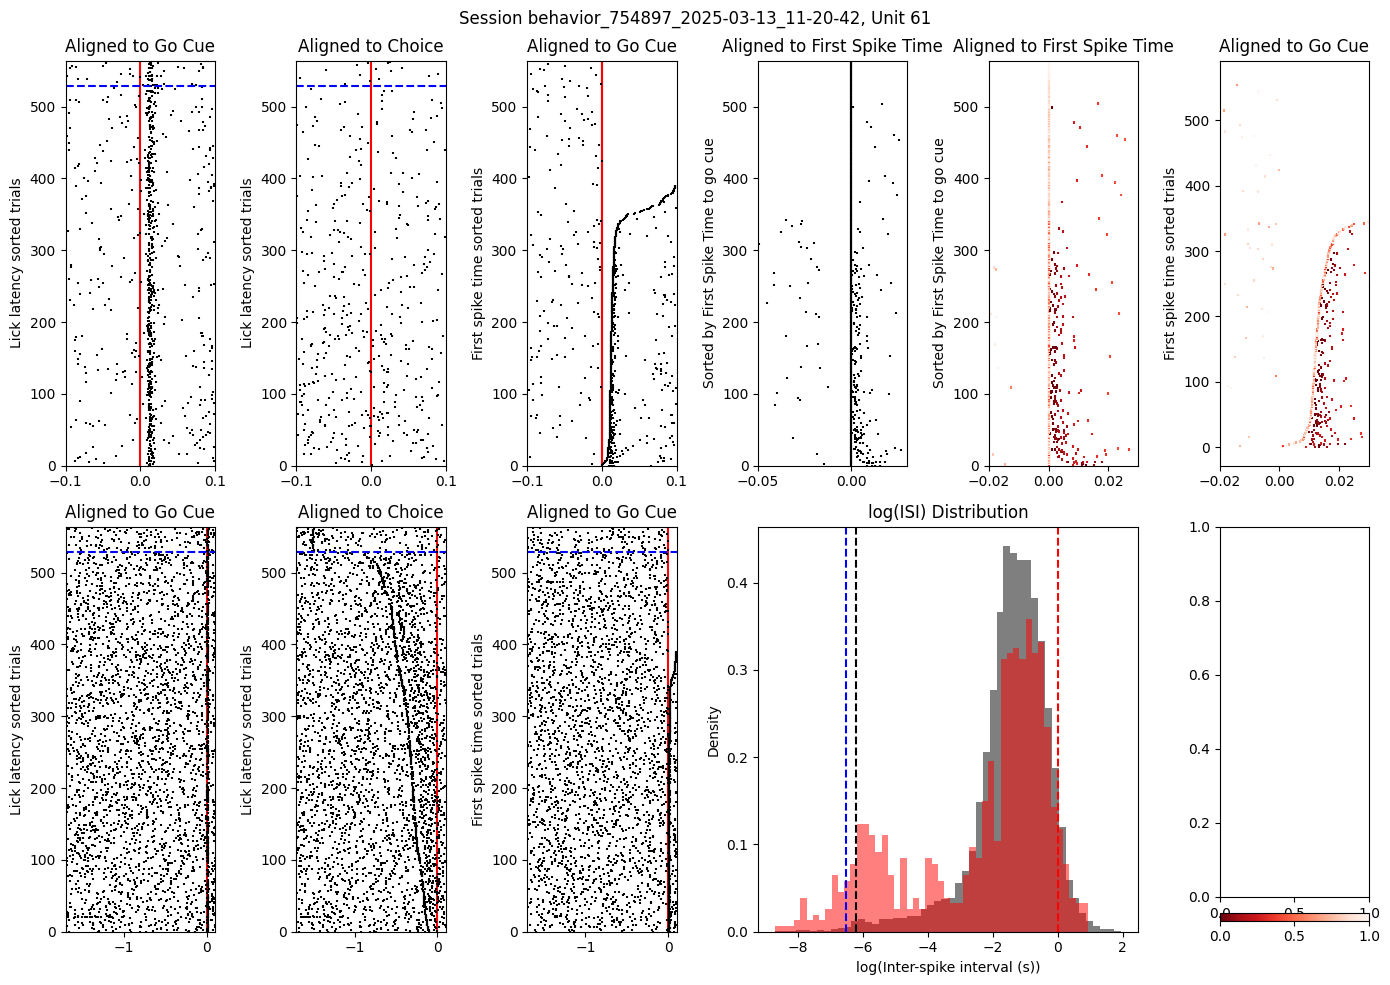

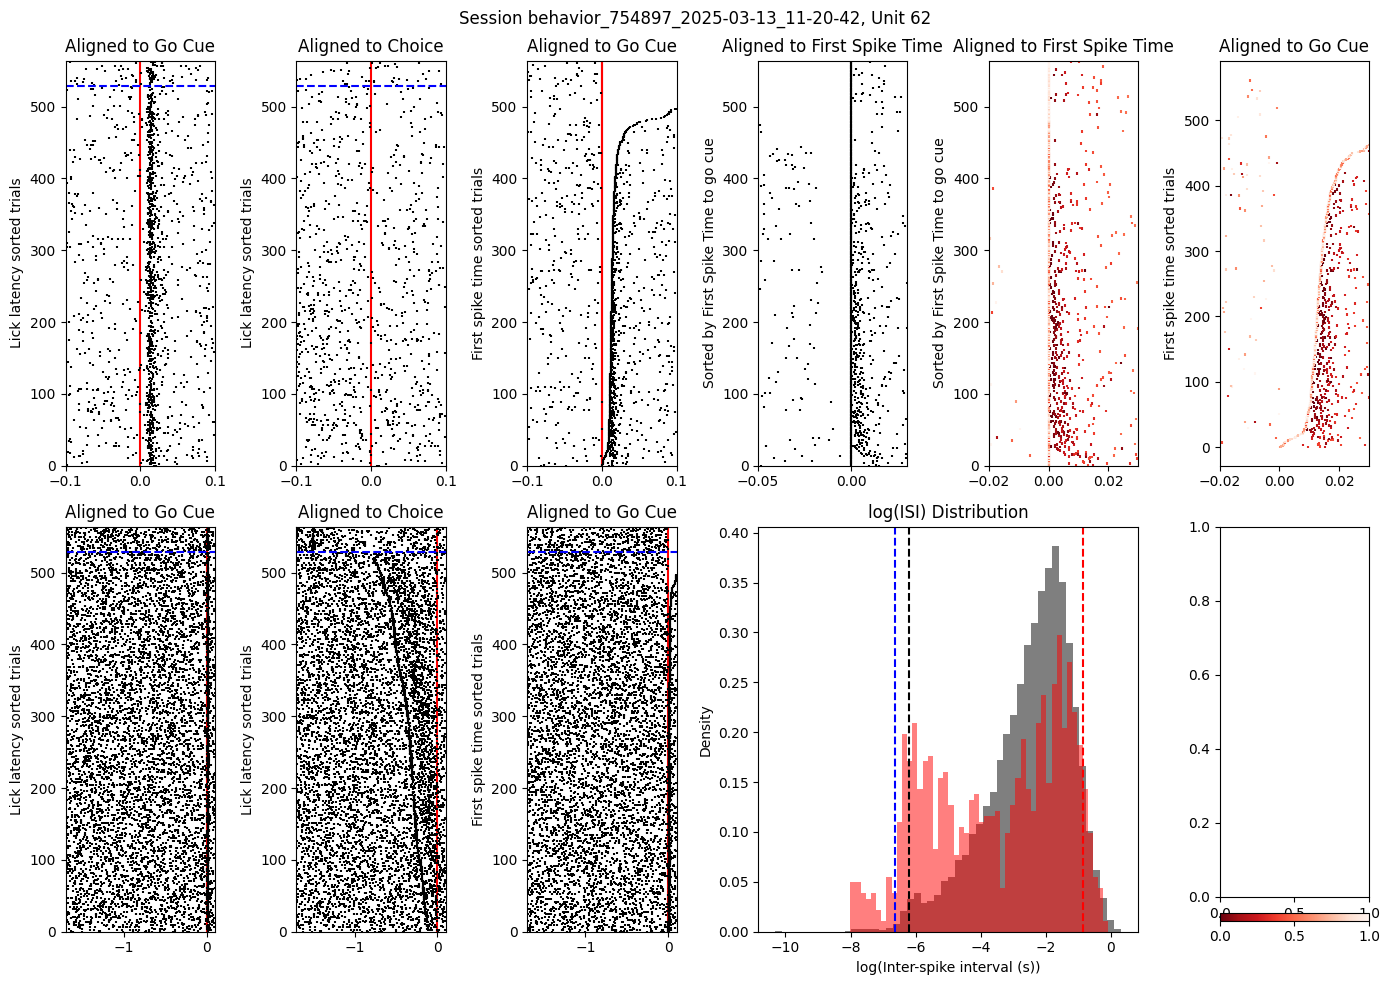

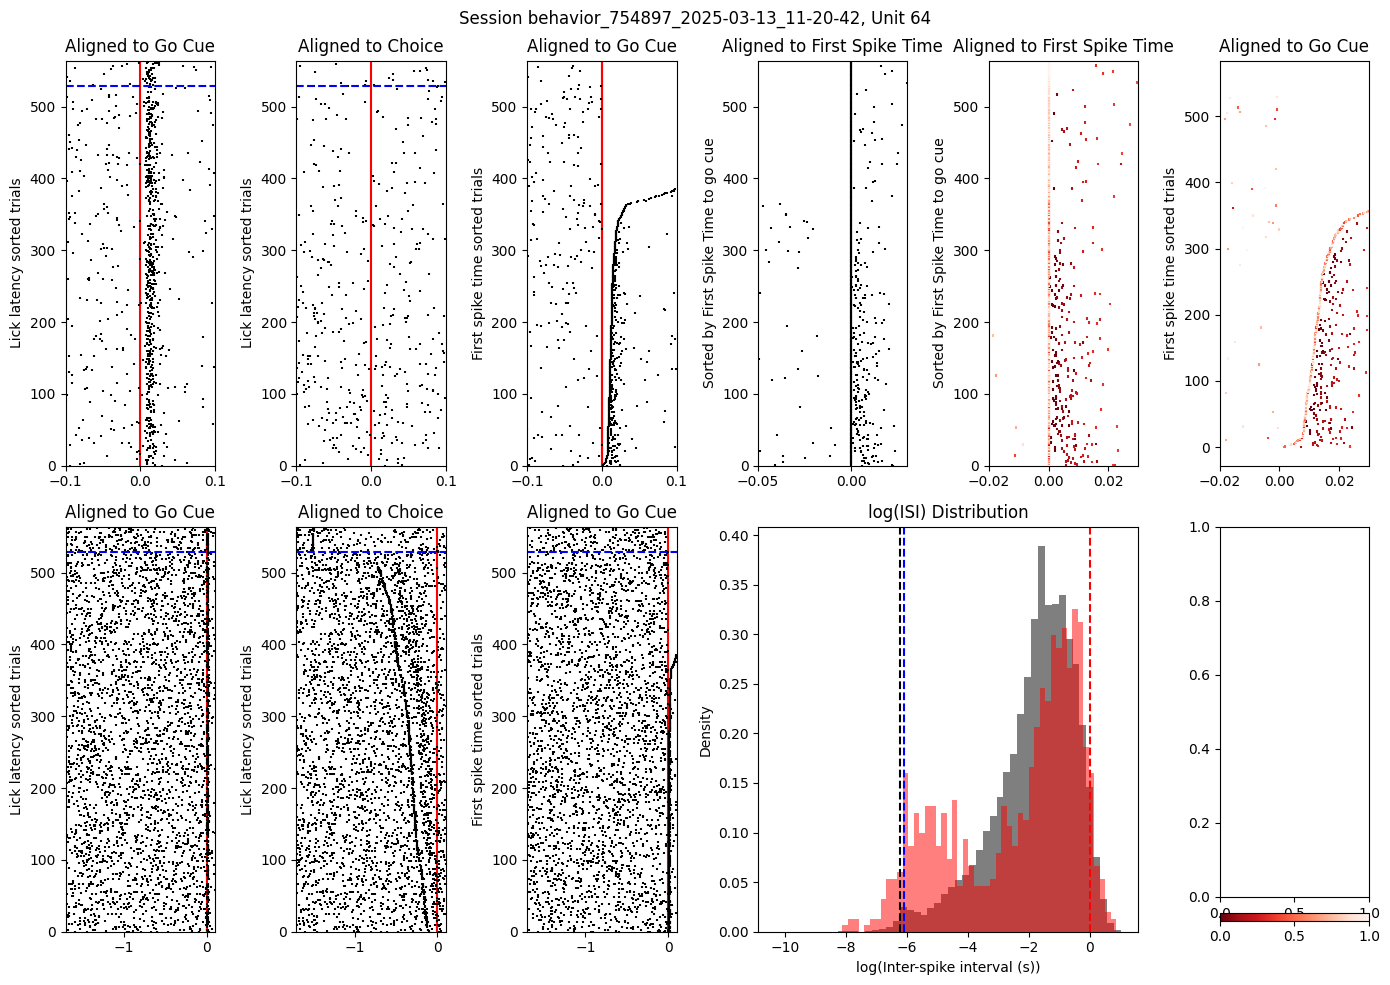

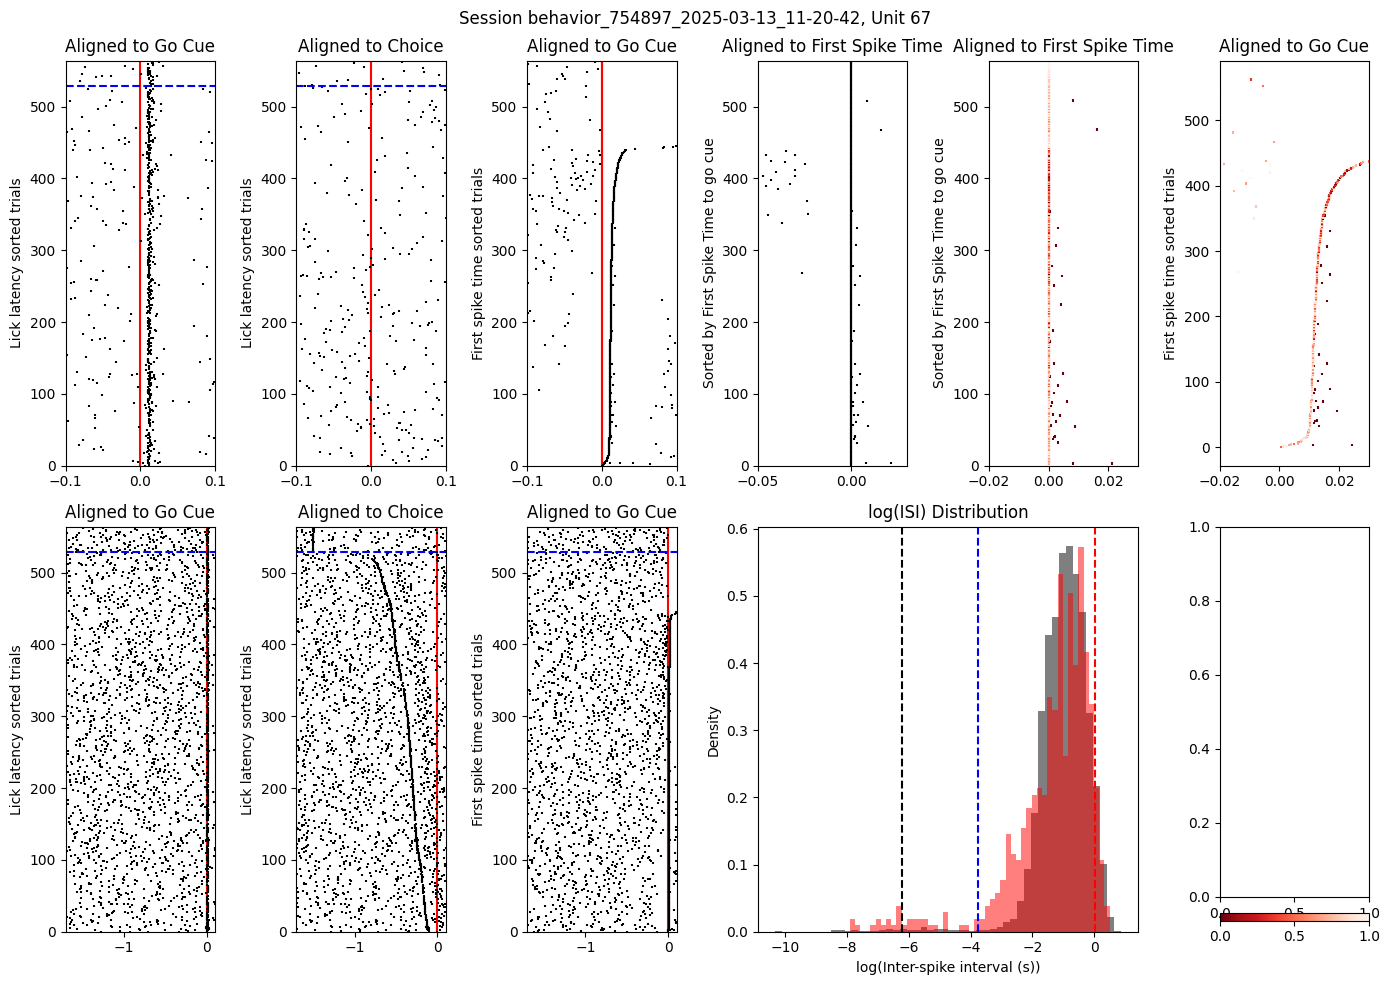

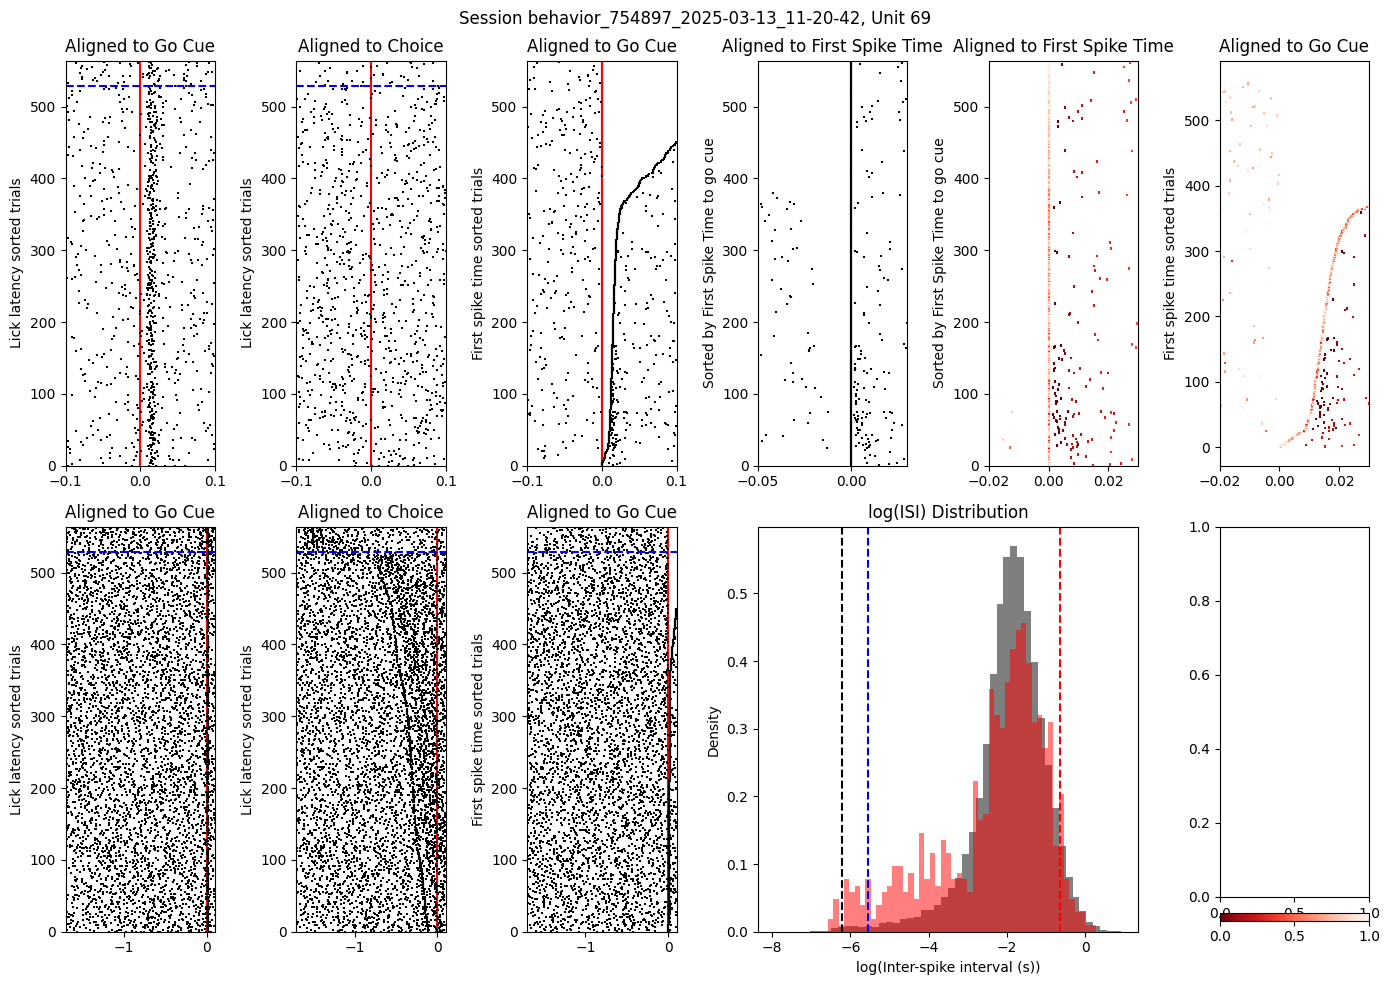

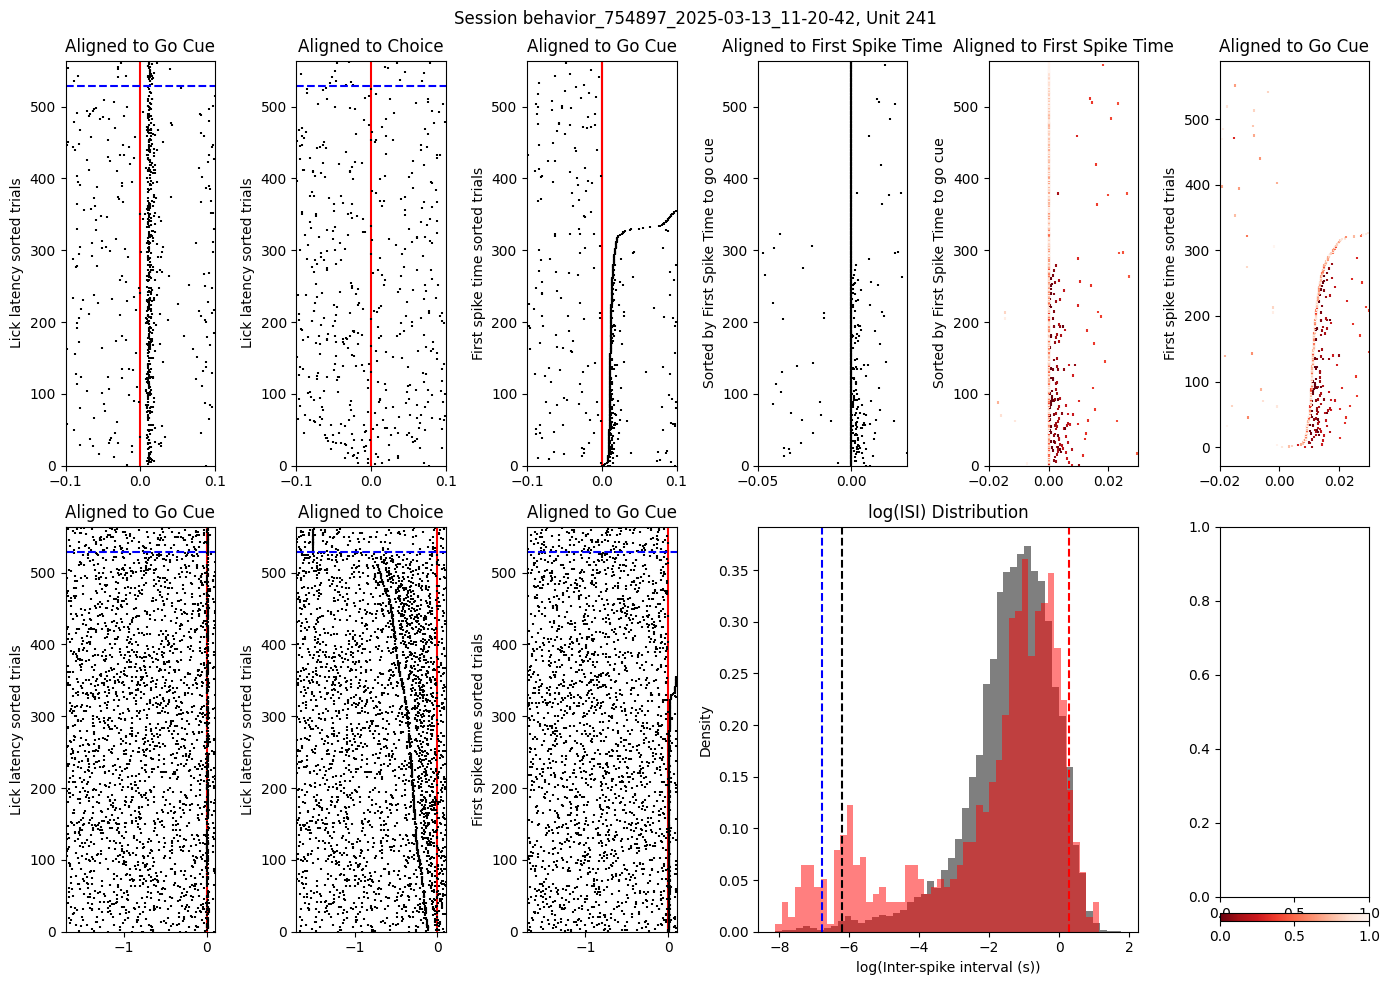

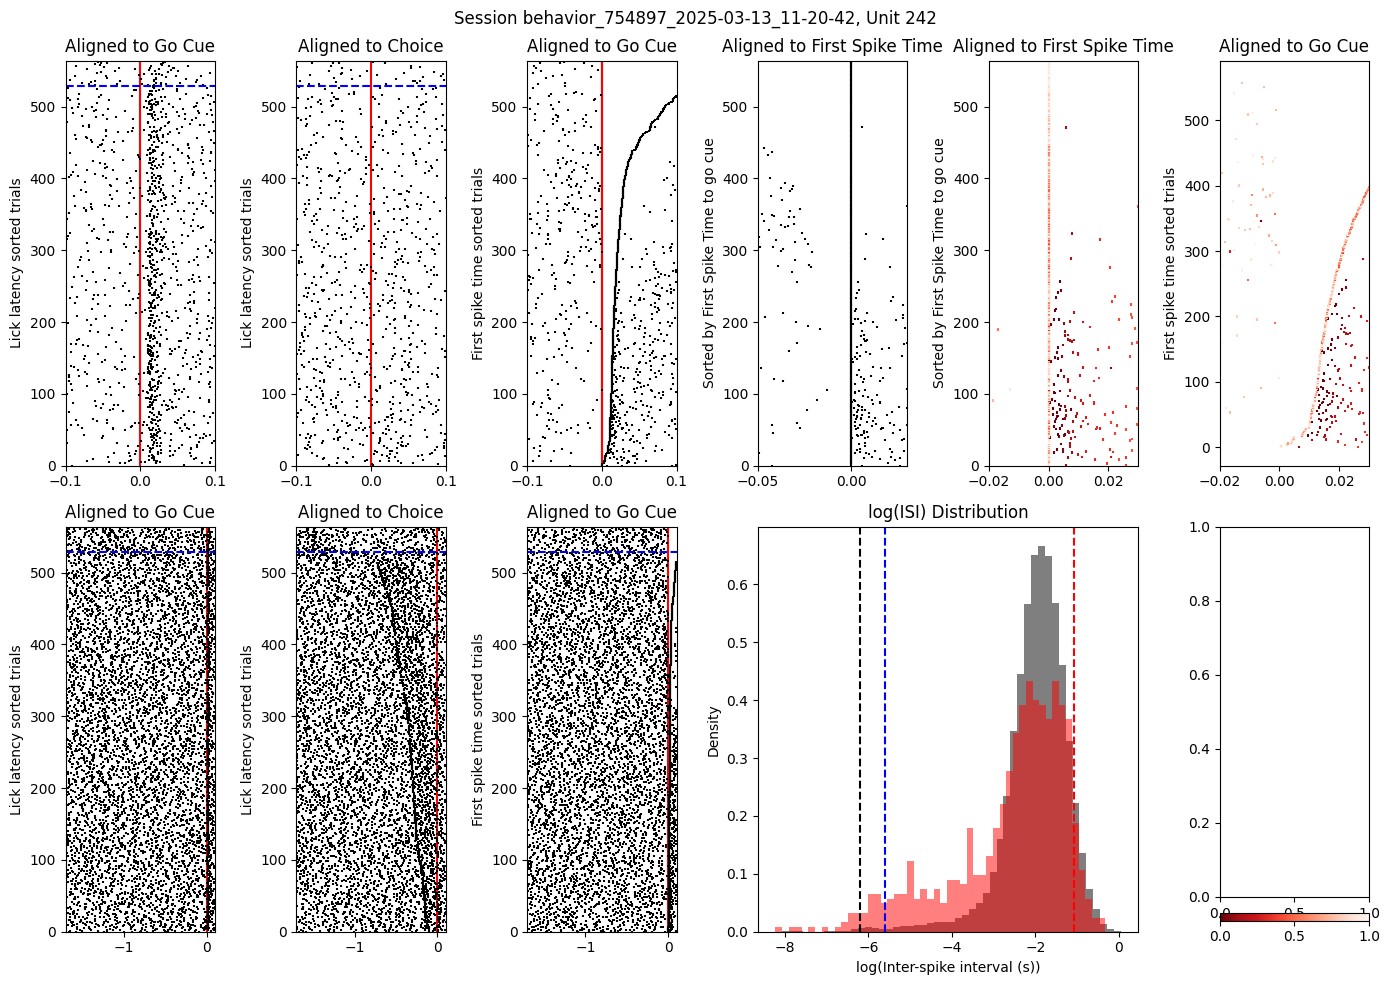

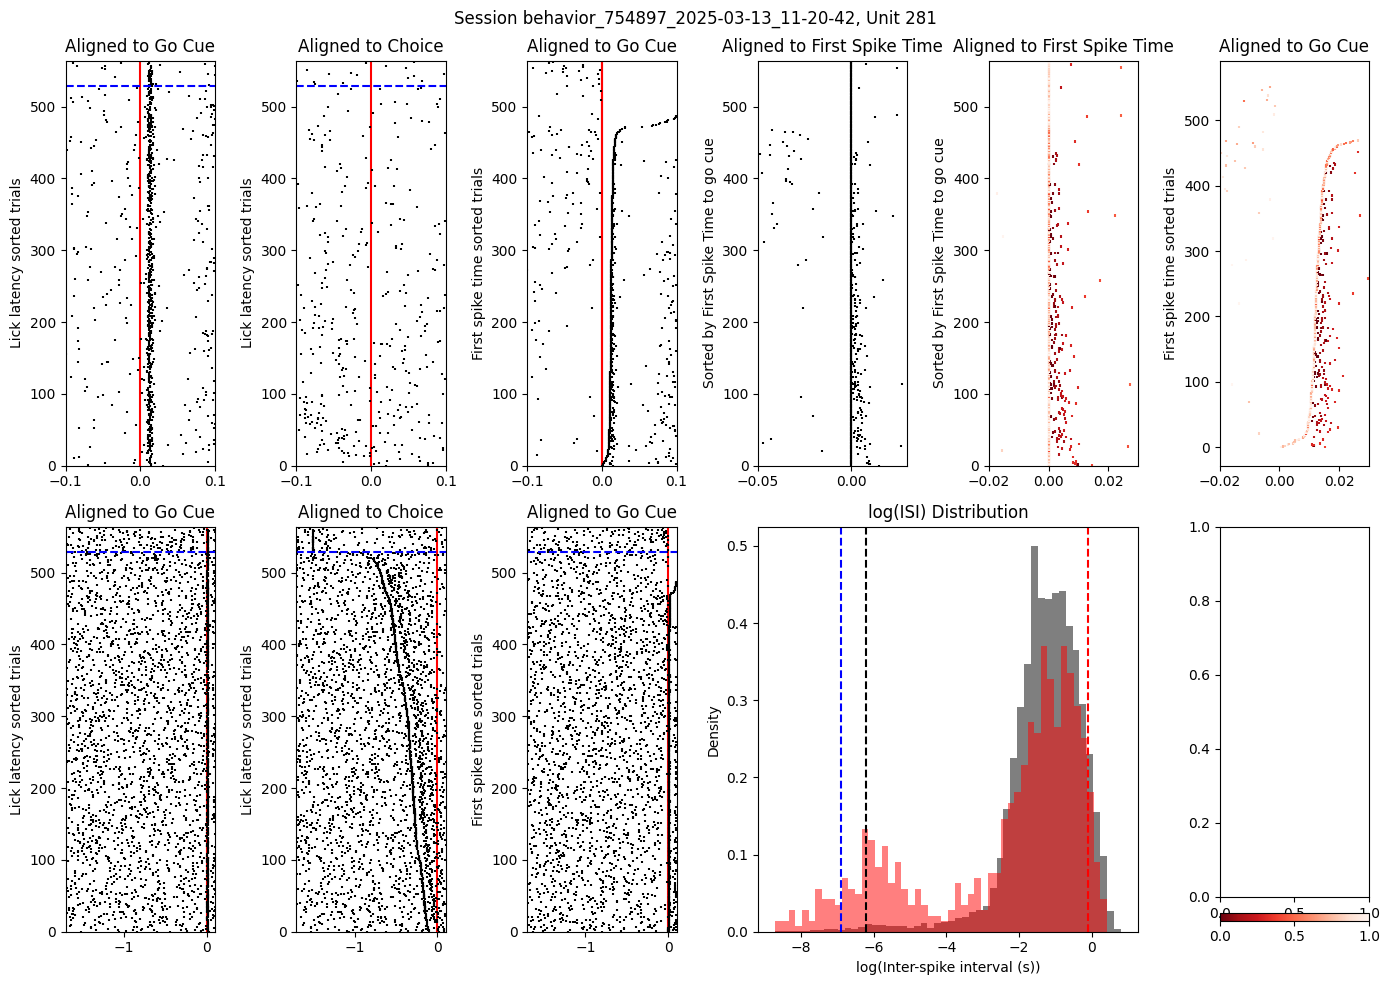

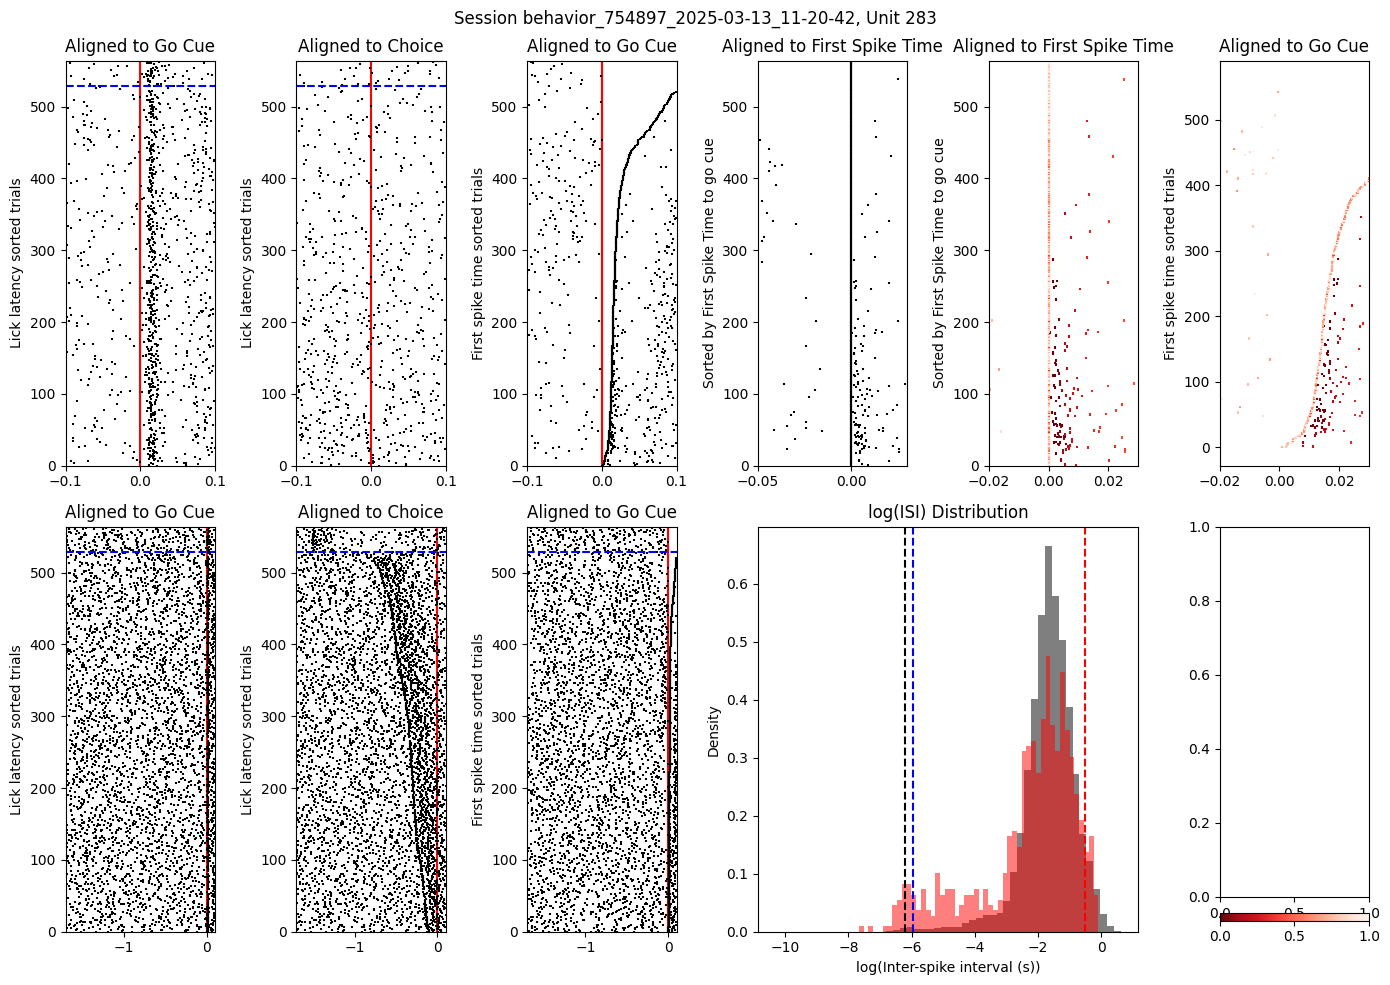

In [25]:
session = 'behavior_754897_2025-03-13_11-20-42'
data_type = 'curated'
units = None
burst_analysis(session, data_type, units = units)

In [35]:
Parallel(n_jobs=-1)(delayed(burst_analysis)(session, 'curated') for session in session_list)

Processing session behavior_716325_2024-05-31_10-31-14 for data type curated
Processing session behavior_717121_2024-06-15_10-00-58 for data type curated
Processing session behavior_751769_2025-01-18_10-15-25 for data type curated
Processing session behavior_758017_2025-02-04_11-57-38 for data type curated
Processing session behavior_751004_2024-12-22_13-09-17 for data type curated
Processing session behavior_751004_2024-12-21_13-28-28 for data type curated
Processing session behavior_751004_2024-12-20_13-26-11 for data type curated
Processing session behavior_751004_2024-12-23_14-20-03 for data type curated
Processing session behavior_758017_2025-02-06_11-26-14 for data type curated
Processing session behavior_751766_2025-02-13_11-31-21 for data type curated
Processing session behavior_751004_2024-12-19_11-50-37 for data type curated
Processing session behavior_751766_2025-02-11_11-53-38 for data type curated
Processing session behavior_751769_2025-01-16_11-32-05 for data type curated

/tmp/ipykernel_28738/2908140627.py:104: RuntimeWarning: invalid value encountered in log


Skipping 75.0 due to insufficient trials after drift cut.
behavior_751004_2024-12-22_13-09-17 Combining PDFs...
Processing 3 files in /root/capsule/scratch/751004/behavior_751004_2024-12-22_13-09-17/ephys/curated/figures/burst
behavior_717121_2024-06-15_10-00-58 Combining PDFs...
Processing 3 files in /root/capsule/scratch/717121/behavior_717121_2024-06-15_10-00-58/ephys/curated/figures/burst
behavior_751004_2024-12-19_11-50-37 Combining PDFs...
Processing 4 files in /root/capsule/scratch/751004/behavior_751004_2024-12-19_11-50-37/ephys/curated/figures/burst
Combined PDF saved as: /root/capsule/scratch/751004/behavior_751004_2024-12-22_13-09-17/ephys/curated/figures/behavior_751004_2024-12-22_13-09-17_bursting.pdf
behavior_751004_2024-12-22_13-09-17 Done!
Processing session behavior_751766_2025-02-14_11-37-11 for data type curated
behavior_758017_2025-02-05_11-42-34 Combining PDFs...
Processing 4 files in /root/capsule/scratch/758017/behavior_758017_2025-02-05_11-42-34/ephys/curated/fi

/tmp/ipykernel_28738/2908140627.py:104: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:169: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:179: RuntimeWarning: invalid value encountered in add
  y += start


Combined PDF saved as: /root/capsule/scratch/751769/behavior_751769_2025-01-17_11-37-39/ephys/curated/figures/behavior_751769_2025-01-17_11-37-39_bursting.pdf
behavior_751769_2025-01-17_11-37-39 Done!
Processing session behavior_758018_2025-03-19_11-16-44 for data type curated
Combined PDF saved as: /root/capsule/scratch/751769/behavior_751769_2025-01-16_11-32-05/ephys/curated/figures/behavior_751769_2025-01-16_11-32-05_bursting.pdf
behavior_751769_2025-01-16_11-32-05 Done!
Processing session behavior_758018_2025-03-20_11-53-05 for data type curated
behavior_758017_2025-02-04_11-57-38 Combining PDFs...
Processing 17 files in /root/capsule/scratch/758017/behavior_758017_2025-02-04_11-57-38/ephys/curated/figures/burst
Combined PDF saved as: /root/capsule/scratch/716325/behavior_716325_2024-05-31_10-31-14/ephys/curated/figures/behavior_716325_2024-05-31_10-31-14_bursting.pdf
behavior_716325_2024-05-31_10-31-14 Done!
Processing session behavior_752014_2025-03-25_12-09-20 for data type cura

/tmp/ipykernel_28738/2908140627.py:104: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:169: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:179: RuntimeWarning: invalid value encountered in add
  y += start


behavior_751766_2025-02-14_11-37-11 Combining PDFs...
Processing 11 files in /root/capsule/scratch/751766/behavior_751766_2025-02-14_11-37-11/ephys/curated/figures/burst
behavior_751181_2025-02-27_11-24-47 Combining PDFs...
Processing 13 files in /root/capsule/scratch/751181/behavior_751181_2025-02-27_11-24-47/ephys/curated/figures/burst
Combined PDF saved as: /root/capsule/scratch/751181/behavior_751181_2025-02-25_12-12-35/ephys/curated/figures/behavior_751181_2025-02-25_12-12-35_bursting.pdf
behavior_751181_2025-02-25_12-12-35 Done!


/tmp/ipykernel_28738/2908140627.py:104: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:169: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:179: RuntimeWarning: invalid value encountered in add
  y += start


Processing session behavior_752014_2025-03-26_11-18-57 for data type curated
behavior_752014_2025-03-25_12-09-20 Combining PDFs...
Processing 4 files in /root/capsule/scratch/752014/behavior_752014_2025-03-25_12-09-20/ephys/curated/figures/burst
behavior_751004_2024-12-21_13-28-28 Combining PDFs...
Processing 16 files in /root/capsule/scratch/751004/behavior_751004_2024-12-21_13-28-28/ephys/curated/figures/burst


/tmp/ipykernel_28738/2908140627.py:104: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:169: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:179: RuntimeWarning: invalid value encountered in add
  y += start


behavior_758018_2025-03-20_11-53-05 Combining PDFs...
Processing 5 files in /root/capsule/scratch/758018/behavior_758018_2025-03-20_11-53-05/ephys/curated/figures/burst
behavior_752014_2025-03-26_11-18-57 Combining PDFs...
Processing 2 files in /root/capsule/scratch/752014/behavior_752014_2025-03-26_11-18-57/ephys/curated/figures/burst
Combined PDF saved as: /root/capsule/scratch/751769/behavior_751769_2025-01-18_10-15-25/ephys/curated/figures/behavior_751769_2025-01-18_10-15-25_bursting.pdf
behavior_751769_2025-01-18_10-15-25 Done!
Processing session behavior_761038_2025-04-15_10-25-11 for data type curated


/tmp/ipykernel_28738/2908140627.py:104: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:169: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:179: RuntimeWarning: invalid value encountered in add
  y += start


Combined PDF saved as: /root/capsule/scratch/752014/behavior_752014_2025-03-26_11-18-57/ephys/curated/figures/behavior_752014_2025-03-26_11-18-57_bursting.pdf
behavior_752014_2025-03-26_11-18-57 Done!
Processing session behavior_761038_2025-04-16_10-39-10 for data type curated
Combined PDF saved as: /root/capsule/scratch/752014/behavior_752014_2025-03-25_12-09-20/ephys/curated/figures/behavior_752014_2025-03-25_12-09-20_bursting.pdf
behavior_752014_2025-03-25_12-09-20 Done!
Processing session behavior_761038_2025-04-18_12-37-39 for data type curated
Combined PDF saved as: /root/capsule/scratch/751004/behavior_751004_2024-12-20_13-26-11/ephys/curated/figures/behavior_751004_2024-12-20_13-26-11_bursting.pdf
behavior_751004_2024-12-20_13-26-11 Done!
Combined PDF saved as: /root/capsule/scratch/751766/behavior_751766_2025-02-13_11-31-21/ephys/curated/figures/behavior_751766_2025-02-13_11-31-21_bursting.pdf
behavior_751766_2025-02-13_11-31-21 Done!
Combined PDF saved as: /root/capsule/scrat

/tmp/ipykernel_28738/2908140627.py:104: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:169: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.10/site-packages/numpy/_core/function_base.py:179: RuntimeWarning: invalid value encountered in add
  y += start


behavior_758018_2025-03-19_11-16-44 Combining PDFs...
Processing 24 files in /root/capsule/scratch/758018/behavior_758018_2025-03-19_11-16-44/ephys/curated/figures/burst
Combined PDF saved as: /root/capsule/scratch/761038/behavior_761038_2025-04-15_10-25-11/ephys/curated/figures/behavior_761038_2025-04-15_10-25-11_bursting.pdf
behavior_761038_2025-04-15_10-25-11 Done!
behavior_754897_2025-03-14_11-28-53 Combining PDFs...
Processing 30 files in /root/capsule/scratch/754897/behavior_754897_2025-03-14_11-28-53/ephys/curated/figures/burst
Combined PDF saved as: /root/capsule/scratch/751766/behavior_751766_2025-02-11_11-53-38/ephys/curated/figures/behavior_751766_2025-02-11_11-53-38_bursting.pdf
behavior_751766_2025-02-11_11-53-38 Done!
behavior_754897_2025-03-13_11-20-42 Combining PDFs...
Processing 37 files in /root/capsule/scratch/754897/behavior_754897_2025-03-13_11-20-42/ephys/curated/figures/burst
Combined PDF saved as: /root/capsule/scratch/758018/behavior_758018_2025-03-19_11-16-44/

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]